## Consumption and Social Network


- This notebook produces the quantitative model results of the paper _Learning from Friends in a Pandemic_ by Christos Makridis and Tao Wang. It adapts QuantEcon's lecture notes on the income flucuation problem. 

  - First, it solves a two-sector consumption model with uninsured idiosyncratic permanent/transitory income risks
       - simulate the histories to match the pre-pandemic consumption inequality across U.S. counties
  - Second, it solves the model with the pandemic where both income and preference depends on a persistently evolving idiosyncratic infection state
    
       - it generates impulse responses following an infection shock 
       
  - Third, it re-simulate the model where the perceived state is formed through social connections, i.e. weighted average of state of the friends 
   
       - it generates impulse responses on 
         - with/without social network
         - when nodes of different social influence is hit by the same sized shock
         - different parameters of EOS

In [1]:
import numpy as np
import pandas as pd
from quantecon.optimize import brent_max, brentq
from interpolation import interp, mlinterp
from scipy import interpolate
from numba import njit, float64, jitclass
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon import MarkovChain
import quantecon as qe 

In [2]:
## figures configurations

mp.rc('xtick', labelsize=14) 
mp.rc('ytick', labelsize=14) 


fontsize = 14
legendsize = 12

In [3]:
## load SCI weight matrix 

W = np.load('SCIWeight.npy')
W16 =  np.load('SCIWeight16.npy')

In [4]:
## load transaction spending data

spend_data= pd.read_stata('../data/spending/spendbycounty.dta')  ## spending by category 
spend_data_sec = pd.read_stata('../data/spending/spendbycounty_bysector.dta')

c_data = np.array(spend_data['ltotal_spend_r'].dropna())  ## spending residuals 
c1_data = np.array(spend_data_sec['ltotal_spend1_r'].dropna())
c2_data =  np.array(spend_data_sec['ltotal_spend2_r'].dropna())


## inverse log to convert it to positive number 
C_data = np.exp(c_data)
C1_data = np.exp(c1_data)
C2_data = np.exp(c2_data)


## income 
y_data = np.array(spend_data['lhhincome'].dropna())
Y_data = np.exp(y_data)

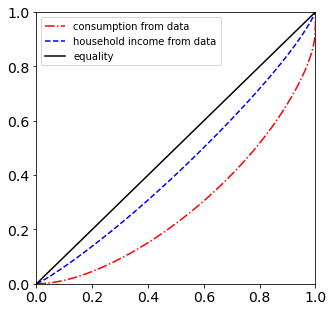

In [5]:
fc_vals, lc_vals = qe.lorenz_curve(C_data)
fc1_vals, lc1_vals = qe.lorenz_curve(C1_data)
fc2_vals, lc2_vals = qe.lorenz_curve(C2_data)


fy_vals, ly_vals = qe.lorenz_curve(Y_data)

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(fc_vals, lc_vals, 'r-.',label='consumption from data')
ax.plot(fy_vals, ly_vals, 'b--',label='household income from data')
ax.plot(fc_vals, fc_vals, 'k-',label='equality')
ax.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

## The model class and solver

In [6]:
ifp_data = [
    ('γ', float64),              # utility parameter CRRA
    ('β', float64),              # discount factor
    ('R',float64),               # Nominal interest rate factor 
    ('P', float64[:, :]),        # transition probs for z_t
    ('z_val', float64[:]),       # values of z 
    ('a_s', float64),            # scale parameter for S_t
    ('b_s', float64),            # additive parameter for S_t
    ('a_y', float64),            # scale parameter for Y_t
    ('b_y', float64),            # additive parameter for Y_t
    ('a_p', float64),            # size of permanent shock Γ_t
    ('a_psi',float64),           ## size of the aggregate shock to reproduction rate  
    ('eps',float64),             # EOS 
    ('s_grid', float64[:]),      # Grid over savings
    ('pshk_draws', float64[:]),  ## Draws of permanent income innovation Γ for MC
    ('η_draws', float64[:]),     # Draws of innovation η for MC
    ('ζ_draws', float64[:])      # Draws of innovation ζ for MC
]

In [7]:
@jitclass(ifp_data)
class IFP:
    """
    A class that stores primitives for the income fluctuation
    problem.
    """

    def __init__(self,
                 γ = 2,
                 β = 0.96,
                 P = np.array([(0.9, 0.1),
                             (0.1, 0.9)]),
                 z_val = np.array([1.0,2.0]), 
                 a_s = 0.02,     ## size of the taste shock  
                 b_s = 0.0,   ## coefficient of pandemic state on taste 
                 a_y = 0.2,     ## size of income risks
                 b_y = 0.0,   ## coefficient of pandemic state on income 
                 a_p = 0.15,     ## size of permanent income shocks
                 a_psi = 0.01,   ## size of reproduction aggregate shocks 
                 eps = 0.75,     ## EOS 
                 R = 1.03,
                 shock_draw_size = 50,
                 grid_max = 4,
                 grid_size = 200,
                 seed = 1234):

        np.random.seed(seed)  # arbitrary seed

        self.γ, self.β = γ, β
        
        self.R = R 
        self.a_s, self.b_s, self.a_y, self.b_y = a_s, b_s, a_y, b_y
        self.a_p = a_p
        self.eps = eps 
        
        self.pshk_draws = a_p*np.random.randn(shock_draw_size)-a_p**2/2
        self.η_draws = np.random.randn(shock_draw_size)-1/2
        self.ζ_draws = np.random.randn(shock_draw_size)-1/2
        self.s_grid = np.linspace(0, grid_max, grid_size)
        
        self.P, self.z_val = P, z_val

        # Test stability assuming {R_t} is IID and adopts the lognormal
        # specification given below.  The test is then β E R_t < 1.
        #ER = np.exp(b_r + a_r**2 / 2)
        assert β * R < 1, "Stability condition failed."

    # Marginal utility
    def u_prime(self, c):
        return c**(-self.γ)

    # Inverse of marginal utility
    def u_prime_inv(self, c):
        return c**(-1/self.γ)

    def ϕ(self, z, ζ):
        ## preference 
        return np.exp(self.a_s * ζ + (z*self.b_s))

    def Y(self, z, η):
        ## income 
        return np.exp(self.a_y * η + (z * self.b_y))
    
    def Γ(self,pshk):
        return np.exp(pshk)

In [8]:
@njit
def K(a_in, σ_in, ifp):
    """
    The Coleman--Reffett operator for the income fluctuation problem,
    using the endogenous grid method.

        * ifp is an instance of IFP
        * a_in[i, z] is an asset grid
        * σ_in[i, z] is consumption at a_in[i, z]
    """

    # Simplify names
    u_prime, u_prime_inv = ifp.u_prime, ifp.u_prime_inv
    R, Y, ϕ, P, β = ifp.R, ifp.Y, ifp.ϕ, ifp.P, ifp.β
    z_val = ifp.z_val
    s_grid, η_draws, ζ_draws = ifp.s_grid, ifp.η_draws, ifp.ζ_draws
    
    ####################
    γ = ifp.γ
    Γ = ifp.Γ
    pshk_draws = ifp.pshk_draws
    ###################
    
    n = len(P)

    # Create consumption function by linear interpolation
    σ = lambda a, z: interp(a_in[:, z], σ_in[:, z], a)

    # Allocate memory
    σ_out = np.empty_like(σ_in)

    # Obtain c_i at each s_i, z, store in σ_out[i, z], computing
    # the expectation term by Monte Carlo
    for i, s in enumerate(s_grid):
        for z in range(n):
            # Compute expectation
            Ez = 0.0
            for z_hat in range(n):
                z_val_hat = z_val[z_hat]
                for η in ifp.η_draws:
                    for pshk in ifp.pshk_draws:
                        Γ_hat = Γ(pshk) ## ϕ_hat taste 
                        Y_hat = Y(z_val_hat, η)
                        U = Γ_hat**(1-γ)*u_prime(σ(R/Γ_hat * s + Y_hat, z_hat))
                        Ez += U * P[z, z_hat]
            Ez = Ez / (len(η_draws)*len(pshk_draws))
            σ_out[i, z] =  u_prime_inv(β * R* Ez)

    # Calculate endogenous asset grid
    a_out = np.empty_like(σ_out)
    for z in range(n):
        a_out[:, z] = s_grid + σ_out[:, z]

    # Fixing a consumption-asset pair at (0, 0) improves interpolation
    σ_out[0, :] = 0
    a_out[0, :] = 0

    return a_out, σ_out

In [9]:
def solve_model_time_iter(model,        # Class with model information
                          a_vec,        # Initial condition for assets
                          σ_vec,        # Initial condition for consumption
                          tol=1e-6,
                          max_iter=2000,
                          verbose=True,
                          print_skip=50):

    # Set up loop
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        a_new, σ_new = K(a_vec, σ_vec, model)
        error = np.max(np.abs(σ_vec - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        a_vec, σ_vec = np.copy(a_new), np.copy(σ_new)

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return a_new, σ_new

In [10]:
@njit
def allocate(c_star,
             p_vec = (1,1),  # price vector
             eps = 0.75,     # EOS
             phi = 0.41,     # SS preference 
             S = 1):          # taste shock multiplied by phi 
    """
    A function that solves sector specific demand given preference shock S and total consumption c_star.
    Other parameters include EOS, steady state share phi and price vector.
    """
    ## price index (depends on the taste shock)
    p_idx = ((S*phi)**eps*p_vec[0]**(1-eps)+(1-phi)**eps*p_vec[1]**(1-eps))**(1/(1-eps))
    c1_star = (S*phi)**eps*p_vec[0]**(-eps)/(p_idx**(1-eps))*c_star
    c2_star = (1-phi)**eps*p_vec[1]**(-eps)/(p_idx**(1-eps))*c_star
    
    return c1_star, c2_star

In [11]:
def policyfunc(ifp,
               a_star,
               σ_star,
               discrete = True):
    """
     * ifp is an instance of IFP
        * a_star is the endogenous grid solution
        * σ_star is optimal consumption on the grid    
    """
    if discrete==True:
        # Create consumption function by linear interpolation
        σ =  lambda a, z_idx: interp(a_star[:, z_idx], σ_star[:, z_idx], a) 
    else:
        # get z_grid 
        z_val = ifp.z_val 

        # Create consumption function by linear interpolation
        a = a_star[:,0]                                ## aseet grid 
        σ =  interpolate.interp2d(a, z_val, σ_star.T) 
    
    return σ

## First, solve the model without the pandemic 
 - optimal consumption policy depending on the infection state, asset level and permanent income
 - given the optimal total consumption and preference shock, solve the allocation problem 

In [12]:
## intialize 

ifp = IFP()

# Initial guess of σ = consume all assets

k = len(ifp.s_grid)
n = len(ifp.P)
σ_init = np.empty((k, n))
for z in range(n):
    σ_init[:, z] = ifp.s_grid
a_init = np.copy(σ_init)

In [13]:
## Set quarterly parameters 

ifp.R = 1.03
ifp.β = 0.96

ifp.a_p = 0.15
ifp.a_y = 0.1

In [14]:
## shut down the income and preference dependence on the infection 

ifp.b_y = 0.0
ifp.b_s = 0.0

In [15]:
a_bf_star, σ_bf_star = solve_model_time_iter(ifp,a_init, σ_init)

Error at iteration 50 is 0.0017101346335515188.
Error at iteration 100 is 0.0004161985516804023.
Error at iteration 150 is 0.00017119710594259985.
Error at iteration 200 is 8.408518701741308e-05.
Error at iteration 250 is 4.466425776672445e-05.
Error at iteration 300 is 2.4675866134638014e-05.
Error at iteration 350 is 1.392279621015291e-05.
Error at iteration 400 is 7.947747586944942e-06.
Error at iteration 450 is 4.566929779237228e-06.
Error at iteration 500 is 2.6341483569947144e-06.
Error at iteration 550 is 1.5226360670084205e-06.

Converged in 589 iterations.


### Plot interpolated policy functions

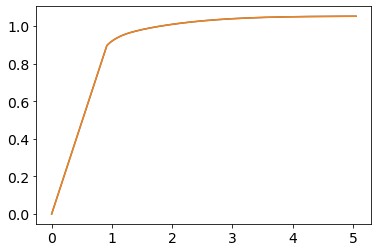

In [16]:
plt.plot(a_bf_star,σ_bf_star)

In [17]:
## interpolate consumption function on continuous z grid 

σ_bf= policyfunc(ifp,
                 a_bf_star,
                 σ_bf_star,
                 discrete = False)

Text(0, 0.5, 'infection')

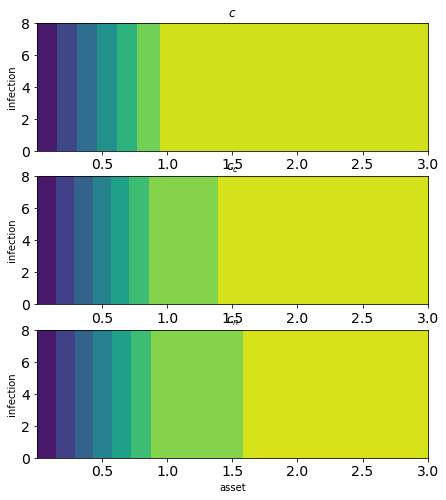

In [18]:
## plot contour for policy function 

a_grid = np.linspace(0.00001,3,20)
z_grid = np.linspace(0,8,20)
aa,zz = np.meshgrid(a_grid,z_grid)

c_stars = σ_bf(a_grid,z_grid)
c1_stars,c2_stars = allocate(c_stars,
                             S = 1)

fig,ax = plt.subplots(3,1,figsize=(7,8))

cp1 = ax[0].contourf(aa, zz,c_stars)
ax[0].set_title(r'$c$')
ax[0].set_xlabel('asset')
ax[0].set_ylabel('infection')

cp2 = ax[1].contourf(aa, zz,c1_stars)
ax[1].set_title(r'$c_c$')
ax[1].set_xlabel('asset')
ax[1].set_ylabel('infection')

cp3 = ax[2].contourf(aa, zz,c2_stars)
ax[2].set_title(r'$c_n$')
ax[2].set_xlabel('asset')
ax[2].set_ylabel('infection')

## Simulate the pre-pandemic history 

In [19]:
#@njit
def simulate_time_series(ifp, σ, z_idx_seq, p_income,T=400):
    """
    Simulates a time series of length T for assets/consumptions, given optimal
    consumption/demand functions.
    * z_seq is a time path for {Z_t} recorded by index, instead of its numeric value

    """
    
    # Simulate the asset path
    a = np.zeros(T)+1e-4
    c  = np.empty_like(a)
    c1 = np.empty_like(a)
    c2 = np.empty_like(a)
    
    ## simulate histories
    ζ_sim = np.random.randn(T)
    η_sim = np.random.randn(T)
    
    
    R = ifp.R
    z_val = ifp.z_val ## values of the state 
    
    
    ## permanent income shocks
    
    Γs = p_income[1:]/p_income[:-1] 
    
    for t in range(T):
        z_idx = z_idx_seq[t]
        z = z_val[z_idx]    
        S = ifp.ϕ(z,ζ_sim[t])
        Y = ifp.Y(z, η_sim[t])
        c[t] = σ(a[t], z_idx)
        c1[t],c2[t] = allocate(c[t], S = S) 
        if t<T-1:
            a[t+1] = R/Γs[t] * (a[t] - c1[t]*p_vec[0]-c2[t]*p_vec[1]) + Y
        
        
    ## multiply permanent income level 
    #c = c*p_income
    #c1 =c1*p_income
    #c2 = c2*p_income
    #a = a * p_income 
    
    return a,c,c1,c2

def simulate_time_series_new(ifp, σ, z_seq, p_income, T=400):
    """
    Simulates a time series of length T for assets/consumptions, given optimal
    consumption/demand functions.

        * ifp is an instance of IFP
        * a_star is the endogenous grid solution
        * σ_star is optimal consumption on the grid
        * z_seq is a time path for {Z_t} recorded by its numeric value (different from the previous function)

    """
    
    # Simulate the asset path
    a = np.zeros(T)+1e-4
    c = np.empty_like(a)
    c1 = np.empty_like(a)
    c2 = np.empty_like(a)
    
    ## simulate histories
    ζ_sim = np.random.randn(T)
    η_sim = np.random.randn(T)
    
    
    R = ifp.R
    #z_val = ifp.z_val ## values of the state 
    
    ## permanent income shocks
    
    Γs = p_income[1:]/p_income[:-1] 
    
    for t in range(T):
        z = z_seq[t] ## z values
        S = ifp.ϕ(z,ζ_sim[t])
        Y = ifp.Y(z, η_sim[t])
        c[t] = σ(a[t], z)
        c1[t],c2[t] = allocate(c[t], S = S) 
        if t<T-1:
            a[t+1] = R/Γs[t] * (a[t] - c1[t]*p_vec[0]-c2[t]*p_vec[1]) + Y
        
    ## multiply permanent income level 
    #c = c*p_income
    #c1 =c1*p_income
    #c2 = c2*p_income
    #a = a * p_income 
    
    return a,c,c1,c2

## now, we simulate the time-series of a cross-sectional matrix of N agents 

#@njit
def simulate_distribution(ifp, 
                          a_star, 
                          p_vec, 
                          σ_star,
                          z_mat, 
                          p_income_mat,
                          N = 3000, 
                          T = 400,
                          discrete = True):
    N_z, T_z = z_mat.shape
    
    assert N_z>=N and T_z >=T, 'history of the markov states are smaller than the simulated matrix'
    
    
    z_mat = z_mat[0:N,0:T]
    ## z_mat is a N_sim x T sized matrix that takes the simulated Markov states 
    a_mat = np.empty((N,T))
    c_mat = np.empty((N,T))
    c1_mat = np.empty((N,T))
    c2_mat = np.empty((N,T))
    
    ## get the policy function
    
    if discrete ==True:
        σ = policyfunc(ifp,
                       a_star,
                       σ_star,
                       discrete = True)  ## interpolate for discrete z index 
        for i in range (N):
            a_mat[i,:],c_mat[i,:],c1_mat[i,:], c2_mat[i,:] = simulate_time_series(ifp,
                                                                                   σ,
                                                                                   z_mat[i,:],
                                                                                   p_income_mat[i,:],
                                                                                   T = T)
    else:
        σ = policyfunc(ifp,
                       a_star,
                       σ_star,
                       discrete = False) ## interpolate for continous z value 
        for i in range (N):
            a_mat[i,:],c_mat[i,:],c1_mat[i,:], c2_mat[i,:] = simulate_time_series_new(ifp,
                                                                                      σ,
                                                                                      z_mat[i,:],
                                                                                      p_income_mat[i,:],
                                                                                      T = T)
            
    ## multiply permanent income level 
    #c_mat= np.multiply(c_mat,p_income_mat)
    #c1_mat = np.multiply(c1_mat,p_income_mat)
    #c2_mat = np.multiply(c2_mat,p_income_mat)
    #a_mat = np.multiply(a_mat,p_income_mat) 

    return a_mat,c_mat,c1_mat, c2_mat

In [20]:
## simulate a Markov sequence 

mc = MarkovChain(ifp.P)

### Simulate history of Idiosyncratic Z states 
#### (For Z to be aggregate state. We can directly copy Z for different agents) 

N = W.shape[0]  ## correspond to # of agents, the length of W matrix
N16 = W16.shape[0]  ## correspond to # of agents, the length of W matrix

T = 25        ## simulated history of time period

z_idx_mat = mc.simulate(T*N, random_state=13274).reshape((N,T))

In [21]:
## simulate a permanent income distributions 

@njit
def PerIncSimulate(T,
                   sigma,
                   init = 0.001):
    pshk_draws = sigma*np.random.randn(T)-sigma**2/2
    log_p_inc = np.empty(T)
    log_p_inc[0] = init
    for t in range(T-1):
        log_p_inc[t+1] = log_p_inc[t]+ pshk_draws[t+1]
    p_income = np.exp(log_p_inc)
    return p_income

@njit
def RWSimulate(T,
               sigma,
               init = 0.001):
    shk_draws = sigma*np.random.randn(T)
    x = np.empty(T)
    x[0] = init
    for t in range(T-1):
        x[t+1] = x[t]+ shk_draws[t+1]
    return x


## simulate histories of permanent income 

p_income_mat = np.empty((N,T))

for n in range(N):
    p_income_mat[n,:] = PerIncSimulate(T,
                                       sigma = ifp.a_p,
                                       init = 0.0001)

In [22]:
## Set the size of the preference volatility to match sub-category inequality 

ifp.a_s = 2.95

In [23]:
## Simulate the distribution of consumption/asset (no social network learning)

p_vec = (1,1) 
a_dist,c_dist,c1_dist,c2_dist = simulate_distribution(ifp,
                                                      a_bf_star,
                                                      p_vec,
                                                      σ_bf_star,
                                                      z_idx_mat,
                                                      p_income_mat,
                                                      N = N,
                                                      T = T,
                                                      discrete = True)

In [24]:
## aggregate history 

co_mat = np.multiply(c_dist,p_income_mat)  ## non-normalized consumption
lco_mat = np.log(co_mat)
lco_av = np.mean(lco_mat,axis = 0)

#p_av =  np.mean(p_income_mat,axis = 0)  
#lp_av = np.log(p_av)
lp_income_mat = np.log(p_income_mat)   ## permanent income level 
lp_av = np.mean(lp_income_mat,axis = 0)

#c_av = np.mean(c_dist,axis=0)
#lc_av = np.log(c_av)
lc_mat = np.log(c_dist)             ## normalized consumption
lc_av = np.mean(lc_mat,axis = 0) 

lc_sd = np.sqrt(np.diag(np.cov(lc_mat.T)))

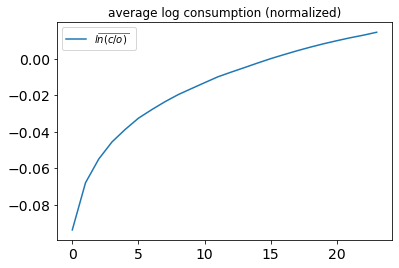

In [25]:
plt.title('average log consumption (normalized)')
plt.plot(lc_av[1:],label = r'$\widebar{ln(c/o)}$')
plt.legend(loc=2)

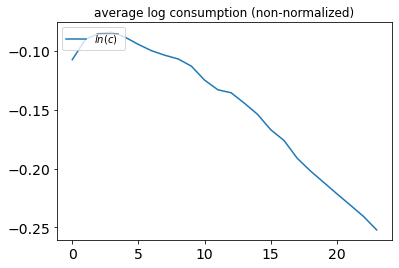

In [26]:
plt.title('average log consumption (non-normalized)')
plt.plot(lco_av[1:],label = r'$\widebar{ln(c)}$')
plt.legend(loc=2)

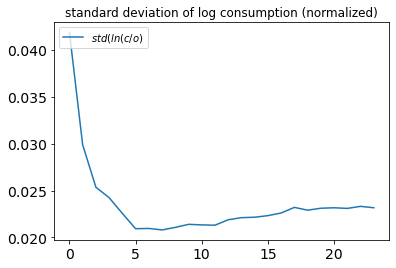

In [27]:
plt.title('standard deviation of log consumption (normalized)')
plt.plot(lc_sd[1:],label = r'$std(ln(c/o)$')
plt.legend(loc=2)

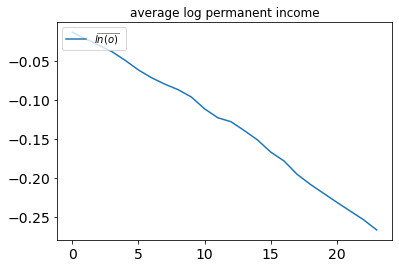

In [28]:
plt.title('average log permanent income')
plt.plot(lp_av[1:],label = r'$\widebar{ln(o)}$')
plt.legend(loc=2)

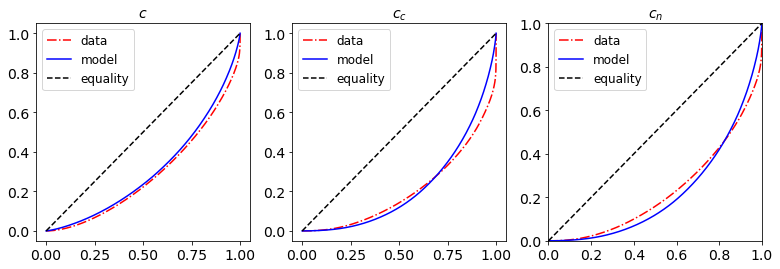

In [29]:
## get lorenz curve of the consumption inequality 

C_model = c_dist[:,-1]
C1_model = c1_dist[:,-1]
C2_model = c2_dist[:,-1]

## multiply by permanent income 
CO_model = np.multiply(c_dist[:,-1],p_income_mat[:,-1])
CO1_model = np.multiply(c1_dist[:,-1],p_income_mat[:,-1])
CO2_model = np.multiply(c2_dist[:,-1],p_income_mat[:,-1])

fc_m_vals, lc_m_vals = qe.lorenz_curve(CO_model)
fc1_m_vals, lc1_m_vals = qe.lorenz_curve(CO1_model)
fc2_m_vals, lc2_m_vals = qe.lorenz_curve(CO2_model)


fig, axs = plt.subplots(1,
                        3,
                        figsize=(13,4))

## total consumption 
axs[0].plot(fc_vals, lc_vals, 'r-.',label='data')
axs[0].plot(fc_m_vals, lc_m_vals, 'b-',label='model')
axs[0].plot(fc_vals, fc_vals, 'k--',label='equality')
axs[0].legend(fontsize=legendsize)
axs[0].set_title(r'$c$',fontsize=fontsize)
#plt.xlim([0,1])
#plt.ylim([0,1])

## conctact consumption 

## total consumption 
axs[1].plot(fc1_vals, lc1_vals, 'r-.',label='data')
axs[1].plot(fc1_m_vals, lc1_m_vals, 'b-',label='model')
axs[1].plot(fc1_vals, fc1_vals, 'k--',label='equality')
axs[1].legend(fontsize=legendsize)
axs[1].set_title(r'$c_c$',fontsize=fontsize)
#plt.xlim([0,1])
#plt.ylim([0,1])


## total consumption 
axs[2].plot(fc2_vals, lc2_vals, 'r-.',label='data')
axs[2].plot(fc2_m_vals, lc1_m_vals, 'b-',label='model')
axs[2].plot(fc2_vals, fc2_vals, 'k--',label='equality')
axs[2].legend(fontsize=legendsize)
axs[2].set_title(r'$c_n$',fontsize=fontsize)
plt.xlim([0,1])
plt.ylim([0,1])

plt.show()
fig.savefig('../graph/model/lorenz_c.jpg')

## Then, solve the model with the pandemic 

   - In theory, we need to solve the consumption policy for a particular aggregate perceived state, namely the perceived reproduction ratio $\tilde \psi_t$;
   - But to a bounded-rationality agent, this perceived state enters the consumption decision as if it is just a constant in the law of motion of the local infection; 
   - Therefore, we only need to solve the policy once for a benchmark agent where the $\tilde \psi_{i,t}=0$. Call it $\sigma(\xi_{i,t},m_{i,t},0)$. The consumption will be a function of local infection $\psi_{i,t}$ and wealth in hand $m_{i,t}$. Then we can obtain the consumption policy of a different agent with the belief of $\tilde \psi_{i,t}$ by the following equation. 
   
\begin{equation}
 \sigma(\xi_{i,t},m_{i,t}, \tilde \psi_{i,t}) =    \sigma(\xi_{i,t}+\tilde \psi_{i,t},m_{i,t}, 0)      
\end{equation}


In [163]:
## parameterization

ifp.b_y = -0.1  ## loading parameters from infection to income
ifp.b_s = -0.2  ## loading parameters from infection to preference 


sigma_eta = 0.209  ## size of the volatility of local infections 
## set the aggregate shock size 
ifp.a_psi= 0.1209  ## size of the volatility of aggregate reproduction ratio

In [31]:
## Pandemic Markov for a bechmark case (aggregate reproduction rate =1, or psi=0)

## feed a markov tanchened from ar1
## these parameters are estimated from Covid19 cases per capita of all U.S. counties during the pandemic 


ρ, σ = (0.999,sigma_eta) ## 0.999 to make it close to a random walk 
                    ## σ=0.209 is the size of idiosyncratic shock or nosiness of the private signals                         
###################################################################
constant = 0.0  ### this is the aggregate transmission rate
#######################################################################
mc = qe.markov.approximation.tauchen(ρ, σ, b=constant, m=3, n=7)
z_ss_av = constant/(1-ρ)
z_ss_sd = σ*np.sqrt(1/(1-ρ**2))

## feed ifp with a markov matrix 
ifp.z_val, ifp.P = mc.state_values, mc.P

## some initial guesses 
k = len(ifp.s_grid)
n = len(ifp.P)
σ_init = np.empty((k, n))
for z in range(n):
    σ_init[:, z] = ifp.s_grid
a_init = np.copy(σ_init)

In [32]:
a_star, σ_star = solve_model_time_iter(ifp,a_init, σ_init)

Error at iteration 50 is 0.0017644275862203074.
Error at iteration 100 is 0.0004333297342367093.
Error at iteration 150 is 0.00020038023086976775.
Error at iteration 200 is 0.0001158394716345712.
Error at iteration 250 is 7.445971548103447e-05.
Error at iteration 300 is 5.0870876058650705e-05.
Error at iteration 350 is 3.612077305792383e-05.
Error at iteration 400 is 2.6319883026815205e-05.
Error at iteration 450 is 1.9528642050237188e-05.
Error at iteration 500 is 1.4679663961014722e-05.
Error at iteration 550 is 1.1140722221358867e-05.
Error at iteration 600 is 8.515454124780053e-06.
Error at iteration 650 is 6.543910507306183e-06.
Error at iteration 700 is 5.04943716983508e-06.
Error at iteration 750 is 3.90847402043093e-06.
Error at iteration 800 is 3.0326121626678137e-06.
Error at iteration 850 is 2.3574026502548584e-06.
Error at iteration 900 is 1.8351680272088444e-06.
Error at iteration 950 is 1.4302207025918001e-06.
Error at iteration 1000 is 1.1155988225985958e-06.

Converged 

In [33]:
## interpolate consumption function on continuous z grid 
σ_= policyfunc(ifp,
               a_star,
               σ_star,
               discrete = False)

Text(0, 0.5, 'infection')

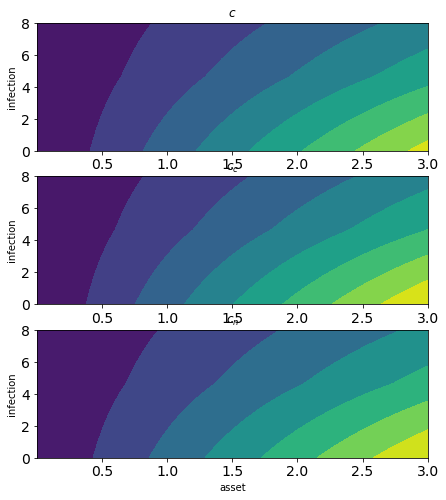

In [34]:
## plot contour for policy function 

a_grid = np.linspace(0.00001,3,20)
z_grid = np.linspace(0,8,20)
aa,zz = np.meshgrid(a_grid,z_grid)

c_stars = σ_(a_grid,z_grid)
c1_stars,c2_stars = allocate(c_stars,S = 1)

fig,ax = plt.subplots(3,1,figsize=(7,8))

cp1 = ax[0].contourf(aa, zz,c_stars)
ax[0].set_title(r'$c$')
ax[0].set_xlabel('asset')
ax[0].set_ylabel('infection')


cp2 = ax[1].contourf(aa, zz,c1_stars)
ax[1].set_title(r'$c_c$')
ax[1].set_xlabel('asset')
ax[1].set_ylabel('infection')


cp3 = ax[2].contourf(aa, zz,c2_stars)
ax[2].set_title(r'$c_n$')
ax[2].set_xlabel('asset')
ax[2].set_ylabel('infection')

## Impulse reponse to an infection shock 

In [35]:
#####################
##  update z ########
#####################

def UpdateNextPeriod(now,
                     psi, # ar(1) persistence 
                     alpha,  ## ar(1) constant
                     sigma): ## ar(1) shock 
    return psi*now+alpha + sigma 


In [36]:
#############################
## continous z state  #
############################

## impulse response function plots the consumption 
##    response after an unexpected +10% shock to the state $Z$ 
#@njit
def irf_(ifp,
        p_vec,    ## price vector
        σ_,
        s_init,        ## initial bank balance distribution
        z_init,        ## initial z distribution
        z_jump = 0.5,  ## shock of z to some fraction of the agents in the economy 
        fraction = 1,
        period = 5):
    
    ## parameters 
    R = ifp.R
    z_val = ifp.z_val
    eps = ifp.eps

    ## simulate impulse responses 
    N = len(s_init)
        
    ## aseet initial
    a_irf = np.empty((N,period))
    a_SS = np.empty((N,period))
    
    ## permanent income
    o_irf = np.empty((N,period))
    for n in range(N):
        n_burn = 10
        o_irf_burn = PerIncSimulate(period+n_burn,
                                    sigma = ifp.a_p,
                                    init = 0.00001)
        
        o_irf[n,:] = o_irf_burn[n_burn:]  ## burn the first 100 simulated observations  
    
    ## psi (aggregate) states
    n_burn = 10
    #psi_irf_burn = RWSimulate(period+n_burn,
    #                          sigma = ifp.a_psi,     ##### need to add a_psi to ifp
    #                          init = 0.00)
    #psi_irf = psi_irf_burn[n_burn:]   ## 
    psi_irf = np.zeros(period)
    psi_SS = np.zeros(period)  ## no aggregate shock in SS 
    
    ## z state initial
    z_SS = np.tile(z_init,(period,1)).T    
    z_irf = np.copy(z_SS)
    
    cutoff_idx = np.int(N*fraction) ## the fracton of the agents shocked, all by default
    z_irf[0:cutoff_idx,0]= z_irf[0:cutoff_idx,0]+z_jump   ## all agents increase by z_jump at time t=1
    
    for t in range(period-1):
        z_irf[:,t+1] = UpdateNextPeriod(z_irf[:,t],
                                        ρ,
                                        psi_irf[t+1],  ########### new 
                                        0.0)   ## no idiosyncratic shock 
    ## z belief state initial
    psi_b_SS = np.tile(psi_SS,(N,1))
    psi_b_irf = np.tile(psi_irf,(N,1))
    
    ## simulate shocks
    ζ_sim = np.random.randn(N,period)-1/2
    η_sim = np.random.randn(N,period)-1/2
    
    ## consumption responses 
    c_irf = np.empty((N,period))
    c1_irf = np.empty((N,period))
    c2_irf = np.empty((N,period))
    c_SS = np.empty((N,period))
    c1_SS = np.empty((N,period))
    c2_SS = np.empty((N,period))
    
    
    ## update initial asset/consumption
    for n in range(N):
        ## irf 
        z = z_irf[n,0]
        S = ifp.ϕ(z,ζ_sim[n,0])
        Y = ifp.Y(z, η_sim[n,0])
        a = s_init[n]+ Y      ############# perceived state 
        a_irf[n,0] = a 
        zpsi = z + psi_b_irf[n,0]   ##### z + perceived psi  
        c_irf[n,0] = σ_(a,zpsi) 
        c1_irf[n,0],c2_irf[n,0] = allocate(c_irf[n,0], 
                                           eps = eps,
                                           S=S) 
        ## SS
        z = z_SS[n,0]
        S = ifp.ϕ(z,ζ_sim[n,0])
        Y = ifp.Y(z, η_sim[n,0])
        a = s_init[n]+ Y
        a_SS[n,0] = a 
        zpsi = z + psi_b_SS[n,0]   ##### z + perceived psi  
        c_SS[n,0] = σ_(a,zpsi)   ##############
        c1_SS[n,0],c2_SS[n,0] = allocate(c_SS[n,0], 
                                         eps = eps,
                                         S=S) 
    
    ## fill the rest of the histories  
    for n in range(N):
        Γs = o_irf[n,1:]/o_irf[n,:-1] 
        for t in range(period-1):
            ## irf
            z = z_irf[n,t]
            S = ifp.ϕ(z,ζ_sim[n,t+1])
            Y = ifp.Y(z, η_sim[n,t+1])
            a = a_irf[n,t]
            a_irf[n,t+1] = R/Γs[t] * (a - c1_irf[n,t]*p_vec[0]-c2_irf[n,t]*p_vec[1]) + Y
            a_new  = a_irf[n,t+1]
            #################################
            zpsi = z + psi_b_irf[n,t+1]   # 
            ###############################
            c_irf[n,t+1] = σ_(a_new,zpsi)
            c1_irf[n,t+1],c2_irf[n,t+1] = allocate(c_irf[n,t+1], 
                                                   eps = eps,
                                                   S=S) 
            
            
            ## SS
            z = z_SS[n,t]
            S = ifp.ϕ(z,ζ_sim[n,t+1])
            Y = ifp.Y(z, η_sim[n,t+1])
            a = a_SS[n,t]
            a_SS[n,t+1] = R/Γs[t] * (a - c1_SS[n,t]*p_vec[0]-c2_SS[n,t]*p_vec[1]) + Y
            a_new  = a_SS[n,t+1]
            zpsi =  z + psi_b_SS[n,t+1]
            c_SS[n,t+1] = σ_(a_new,zpsi)
            c1_SS[n,t+1],c2_SS[n,t+1] = allocate(c_SS[n,t+1], 
                                                 eps = eps,
                                                 S=S) 
            
    
    ## multiply asset/consumption by permanent income level 
    #c_irf= np.multiply(c_irf,o_irf)
    #c1_irf = np.multiply(c1_irf,o_irf)
    #c2_irf = np.multiply(c2_irf,o_irf)
    #a_irf = np.multiply(a_irf,o_irf) 
    #c_SS = np.multiply(c_SS,o_irf)
    #c1_SS = np.multiply(c1_SS,o_irf)
    #c2_SS = np.multiply(c2_SS,o_irf)
    #a_SS = np.multiply(a_SS,o_irf) 
    
    
    ## get the cross-sectional average 
    z_irf,psi_b_irf = np.mean(z_irf,axis=0),np.mean(psi_b_irf,axis=0)
    c_irf, c1_irf,c2_irf = np.mean(np.log(c_irf),axis=0), np.mean(np.log(c1_irf),axis=0),np.mean(np.log(c2_irf),axis=0)
    a_irf = np.mean(np.log(a_irf), axis=0)  
    
    z_SS,psi_b_SS = np.mean(z_SS,axis=0),np.mean(psi_b_SS,axis=0)
    c_SS, c1_SS,c2_SS = np.mean(np.log(c_SS),axis=0), np.mean(np.log(c1_SS),axis=0),np.mean(np.log(c2_SS),axis=0) 
    a_SS = np.mean(np.log(a_SS), axis=0)
    
    return z_irf, psi_b_irf, a_irf, c_irf, c1_irf, c2_irf, z_SS, psi_b_SS, a_SS, c_SS, c1_SS, c2_SS

In [38]:
## steady state asset and states 
s_SS_init = a_dist[:,-1]-c_dist[:,-1]
N = s_SS_init.shape[0]
z_SS_init = (z_ss_av+0.00000001)*np.ones(N)

In [39]:
## get the impulse responses
ifp.eps = 0.75
z_irf,psi_b_irf,a_irf, c_irf, c1_irf,c2_irf,z_SS,psi_b_SS,a_SS, c_SS, c1_SS,c2_SS = irf_(ifp,
                                                                                      p_vec,
                                                                                      σ_,
                                                                                      s_SS_init,
                                                                                      z_SS_init,
                                                                                      z_jump = 0.1,
                                                                                      fraction = 1.0,
                                                                                      period = 20)

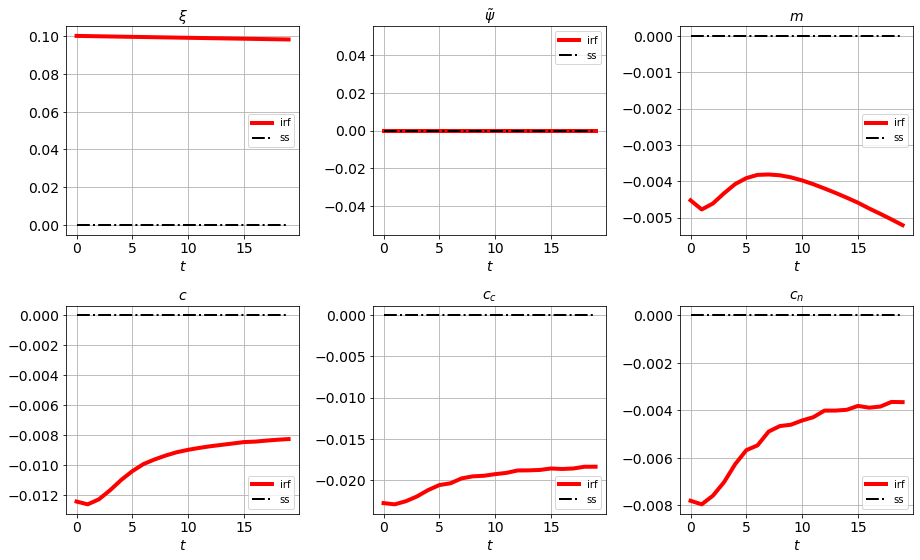

In [40]:
## plot impulses reponses

fig, axs = plt.subplots(2,3, 
                        figsize=(13, 8), 
                        facecolor='w', 
                        edgecolor='k')

irf_plot = [z_irf, psi_b_irf, a_irf, c_irf, c1_irf,c2_irf]
ss_plot =  [z_SS, psi_b_SS, a_SS, c_SS, c1_SS,c2_SS]

names = [r'$\xi$',r'$\tilde \psi$',r'$m$',r'$c$',r'$c_c$',r'$c_n$']

axs = axs.ravel()

for i, var in enumerate(irf_plot):
    compared_to_SS = var- ss_plot[i]  ## plot the relative differences with SS
    rebase_SS = np.zeros(len(var))    ## set SS to be zero
    axs[i].plot(compared_to_SS,
                'r-',
                lw = 4,
               label = 'irf')
    #axs[i].set_xticks(np.arange(1,len(var)+2))
    axs[i].plot(rebase_SS,
               'k-.',
               lw = 2,
               label ='ss')
    axs[i].set_title(names[i], fontsize=fontsize)
    axs[i].set_xlabel(r'$t$', fontsize=fontsize)
    axs[i].legend(loc=0)
    axs[i].grid()
fig.tight_layout(pad=1.5)
plt.savefig('../graph/model/irf_baseline_new.jpg')

## Simulate markov sequence of underlying state and the belief states

In [263]:
@njit
def UpdateBeliefGeneral(belief_vec_prior, ## \tilde \psi_t vector
                        s,  ## surprises vector 
                        W,  ## listening matrix 
                        κ, ## 1-information gains vector Nx1
                        λ):  ## social_weight, scalor 
    ## turn vectors to matrix
    N = len(belief_vec_prior)
    H = np.ones(N)
    M = (1-λ)*np.diag(κ)+λ*W
    belief_vec_post = M@belief_vec_prior+ (1-λ)*np.diag(H-κ)@s
    return belief_vec_post.flatten()

@njit
def SimulateHistories(N,
                      T,
                      σ_eta,
                      σ_theta,
                      σ_init_xi,   ## initial idiosynratic state variance
                      initials_psi): ## initial aggregate state  
    xi_init = np.random.randn(N)*σ_init_xi
    theta_draws = np.random.randn(T)*σ_theta
    ## aggregate shocks 
    psi_draws = np.empty(T)
    psi_draws[0] = initials_psi
    for t in range(T-1):
        psi_draws[t+1] = psi_draws[t]+theta_draws[t+1]
    ## idiosyncratic shocks 
    eta_draws = np.random.randn(N,T)*σ_eta
    
    ## histories 
    xi_draws = np.empty((N,T))
    xi_draws[:,0] = xi_init
    for i in range(N):
        for t in range(T-1):
            xi_draws[i,t+1] = xi_draws[i,t]+eta_draws[i,t+1]+psi_draws[t+1] 
    return psi_draws,xi_draws  ## N x T 

def UpdateBeliefDistFromVal(s_mat, ## histories of surprises 
                            W,      ## listening matrix  N x N 
                            k_mat,  ## 11-information gains matrix N x T 
                            λ):
    N,T = s_mat.shape
    ### histories of surprises 
    #s_sim = z_mat[:,1:]-z_mat[:,:-1]
    ### create belief matrix 
    psi_beliefs_burn = np.empty((N,T+1))
    
    ### initial prior 
    sigma_prior = 0.00  ## the bigger the more dispersed the initial priors 
    #np.random.seed(12356)
    init_priors = sigma_prior*np.random.randn(N)
    psi_beliefs_burn[:,0] = init_priors
    
    
    ### update the beliefs 
    for t in range(T):
        prior_this_time = psi_beliefs_burn[:,t]
        s_sim_this_time = s_mat[:,t]
        k_sim_this_time = k_mat[:,t]
        psi_beliefs_burn[:,t+1] = UpdateBeliefGeneral(prior_this_time,
                                                      s_sim_this_time,
                                                      W,
                                                      k_sim_this_time,
                                                      λ)
    psi_beliefs = psi_beliefs_burn[:,1:]
    
    return psi_beliefs

@njit
def discrete2continuous(z_idx_mat,
                       z_val):
    N,T = z_idx_mat.shape
    z_mat = np.zeros((N,T))
    
    for i in range(z_mat.shape[0]):
        for j in range(z_mat.shape[1]):
            z_idx = z_idx_mat[i,j]
            z_mat[i,j] = z_val[z_idx]
    return z_mat

In [42]:
## simulated histories and belief histories belef histories 


## parameters 
#λ_sim = 0.99  ## social weight 
#W_sim = W    ## listening matrix  
#k_sim = 0.9*np.ones((N,N))   ## constant kalman gain from private surprises 

#psi_beliefs_sim = UpdateBeliefDistFromVal(xi_sim,
#                                          W_sim,
#                                          k_sim,
#                                          λ_sim)

In [234]:
## simulate beliefs


## convert the markov matrix of index to a matrix of values of z
z_val = ifp.z_val  ## get the vector of the values of z grid
z_mat = discrete2continuous(z_idx_mat,
                            z_val)


## parameters 

W_sim = W
k_mat_sim = 0.30*np.ones((N,N))
λ_sim = 0.50

In [235]:
psi_belief = UpdateBeliefDistFromVal(z_mat,
                                     W_sim,      ## listening matrix  N x N 
                                     k_mat_sim,  ## 11-information gains matrix N x T 
                                     λ_sim)

25


<ipython-input-233-4f9414cf1965>:11: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  belief_vec_post = M@belief_vec_prior+ (1-λ)*np.diag(H-κ)@s
/Users/Myworld/anaconda3/lib/python3.7/site-packages/numba/typing/npydecl.py:958: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/Users/Myworld/anaconda3/lib/python3.7/site-packages/numba/typing/npydecl.py:958: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


24


In [236]:
## with social network learning 

zpsi_belief = z_mat + psi_belief

pa_dist,pc_dist,pc1_dist,pc2_dist = simulate_distribution(ifp, 
                                                          a_star, 
                                                          p_vec, 
                                                          σ_star,
                                                          zpsi_belief,
                                                          p_income_mat,
                                                          N = N,
                                                          T = T,
                                                          discrete = False)

ValueError: operands could not be broadcast together with shapes (3141,25) (3141,24) 

In [46]:
## compute cross-sectional summary statistics

## average pattern

lc_dist = np.log(c_dist) 
lc_av = np.mean(lc_dist,axis = 0)

lpc_dist = np.log(pc_dist) 
lpc_av = np.mean(lpc_dist,axis = 0)

## correlation
lc_sd = np.sqrt(np.diag(np.cov(lc_dist.T)))
lpc_sd = np.sqrt(np.diag(np.cov(lpc_dist.T)))

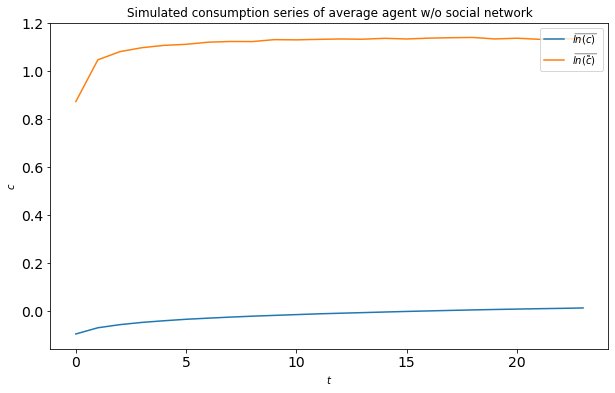

In [47]:
## plot the average consumption 

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(lc_av[1:],label = r'$\widebar{ln(c)}$')
ax.plot(lpc_av[1:],label = r'$\widebar{ln(\tilde c)}$')
ax.set(xlabel=r'$t$')
ax.set(ylabel=r'$c$')
plt.title('Simulated consumption series of average agent w/o social network')
plt.legend(loc=1)
plt.show()

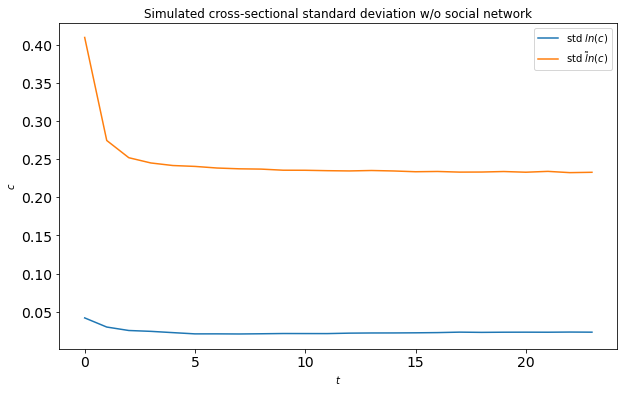

In [48]:
## plot the cross-sectional correlation of non-contact-based consumption

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(lc_sd[1:],label = r'std $ln(c)$')
ax.plot(lpc_sd[1:],label = r'std $\tilde ln(c)$')
ax.set(xlabel=r'$t$')
ax.set(ylabel=r'$c$')
plt.title('Simulated cross-sectional standard deviation w/o social network')
plt.legend(loc=1)
plt.show()

## Impulse response with social network learning 

- plots the impulse response of average beliefs about the aggregate state and consumption responses after a one-time exogeous jump from low infection to high state of some fraction/or all agents
- the prior belief of all agents are assumed to be correct (equal to the true state and no dispersion) in order to attribute all changes of beliefs to the one-time shocks
- aggregate shock is also assumed away thus the aggregate state stay at a constant level

In [49]:
##############################################################
## analytical functison of IRFs to an aggregate shock and idiosycratic shocks
#########################################################################

def irf_ag(k,
           λ,
           W, ## listening matrix 
           v): ## steps of IRF
    """
    this is to operate on matrix, very slow. 
    actually it is not a function of W. So can use irf_ag_simple functions.
    but i still include it for comparison purpose 
    """
    
    N = len(W)
    H = np.ones(N)
    Iκ = (1-k)*H   ## I-\kappa
    X0 = 1/N*k*(1-λ)
    M = (1-λ)*np.diag(Iκ)+λ*W
    irf = 0.0
    for s in range(v+1):
        Ms = np.linalg.matrix_power(M,s)
        #########
        HMsH = Ms.sum()
        #############
        Xs = X0*HMsH
        irf = irf+Xs
    return irf

def irf_ag_simple(k,
                  λ,
                  v):
    x0 = k*(1-λ)
    rho =(1-λ)*(1-k)+λ  ## this is the summary statistic of the average belief 
    irf = 0.0
    for s in range(v+1):
        xv = x0*(rho)**s
        irf = irf+xv
    return irf

def irf_id_c(k,
             λ, 
             W,  ## listening matrix 
             v,  ## steps of IRF
             Z): ## new addition, a vector of 1/0s deciding wheather the shock hit there
    
    N = len(W)
    H = np.ones(N)
    
    Iκ = (1-k)*H
    X0 =1/N*k*(1-λ)
    M = (1-λ)*np.diag(Iκ)+λ*W
    Mv = np.linalg.matrix_power(M,v)
    #####
    ## different for ag and id
    HMvZ = H@Mv@Z
    ######
    Xv = X0*HMvZ
    irf = Xv
    return irf

#### How does aggregate IRF depends on k and $\lambda$

In [50]:
## compute IRFs 

grid_size = 20

k_vals = np.linspace(0.001, 2, grid_size)
λ_vals = np.linspace(0.001, 0.99, grid_size)

## generate IRFs for different v
vs = [0,1,2,3]

IRF_ags_ls= []

for v_id,v in enumerate(vs):
    IRF_ags = np.empty((grid_size, grid_size))
    for i, k in enumerate(k_vals):
        for j, λ in enumerate(λ_vals):
            #IRF_ags[i, j] = irf_ag(k,λ,W,v)
            IRF_ags[i, j] = irf_ag_simple(k,
                                          λ,
                                          v)
    IRF_ags_ls.append(IRF_ags)

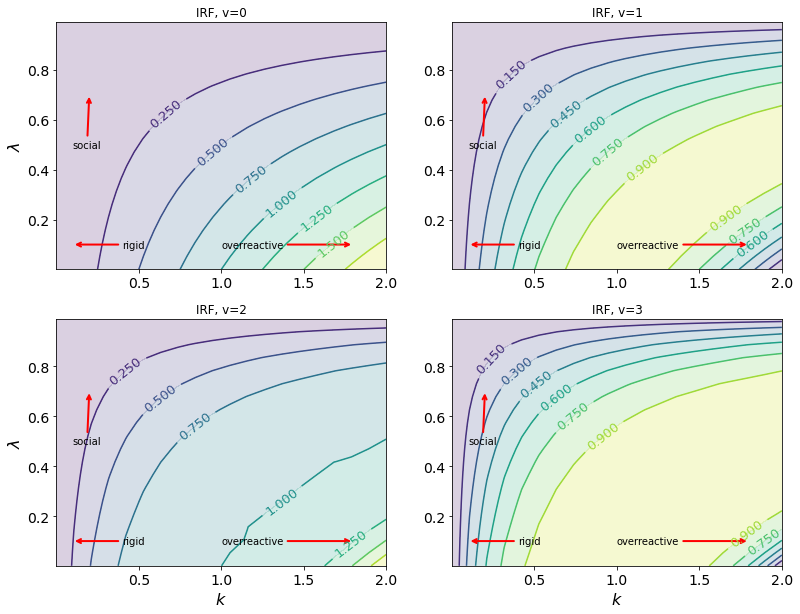

In [51]:
#levels = np.array([0.0,0.2,0.4,0.6,0.8,1.0,1.5])

## plot 
fig, ax = plt.subplots(2,2,figsize=(13,10))
ax = ax.ravel()

for v_id,v in enumerate(vs):
    this_IRF_ags = IRF_ags_ls[v_id]
    cs1 = ax[v_id].contourf(k_vals, λ_vals, this_IRF_ags.T, alpha=0.2)
    ctr1 = ax[v_id].contour(k_vals, λ_vals, this_IRF_ags.T)
    plt.clabel(ctr1, inline=1, fontsize=13)
    #plt.colorbar(cs1, ax=ax)
    ax[v_id].set_title(r'IRF, v={}'.format(v))
    ax[2].set_xlabel("$k$", fontsize=16)
    ax[3].set_xlabel("$k$", fontsize=16)
    ax[0].set_ylabel("$λ$", fontsize=16)
    ax[2].set_ylabel("$λ$", fontsize=16)
    
    ax[v_id].ticklabel_format(useOffset=False)

    ax[v_id].annotate('overreactive', xy=(1.8,0.1),
                xytext=(1.0,0.1), va='center', multialignment='right',
                arrowprops={'arrowstyle': '->', 'lw': 2, 'ec': 'r'})
    
    ax[v_id].annotate('rigid', xy=(0.1,0.1),
                xytext=(0.4,0.1), va='center', multialignment='right',
                arrowprops={'arrowstyle': '->', 'lw': 2, 'ec': 'r'})

    ax[v_id].annotate('social', xy=(0.2,0.7),
                xytext=(0.1,0.5), va='center', multialignment='right',
                arrowprops={'arrowstyle': '->', 'lw': 2, 'ec': 'r'})
    

plt.savefig('../graph/model/IRF_ag_contourf.jpg')

#### The time path of the IRF

In [52]:
k_fix = 1.5
k_vals = np.array([0.3,1,1.7])
λ_vals = np.array([0.01,0.3,0.8,0.99])
v_vals = np.arange(10)

In [53]:
IRF_ag_path = np.empty((len(k_vals),len(λ_vals), len(v_vals)))
                       
for j,k in enumerate(k_vals):
    for i, λ in enumerate(λ_vals):
        for t, v in enumerate(v_vals):
            IRF_ag_path[j,i,t] = irf_ag_simple(k,
                                              λ,
                                              v)

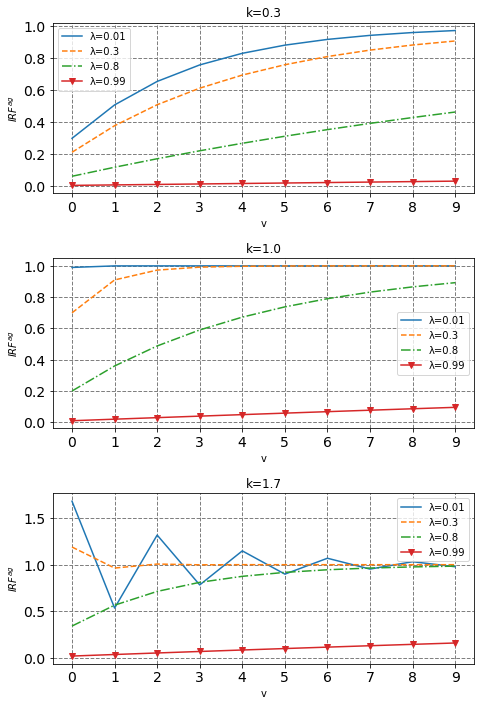

In [54]:
lp_ls=['-','--','-.','v-']
nb_plots = len(k_vals)

fig,ax =plt.subplots(nb_plots,1,figsize=(7,10))
ax = ax.ravel()

for j,k in enumerate(k_vals):
    for i,λ in enumerate(λ_vals):
        ax[j].plot(IRF_ag_path[j,i,:],
                lp_ls[i],
               label =r'λ={}'.format(λ))
        ax[j].set_xlabel('v')
        ax[j].set_ylabel(r'$IRF^{ag}$')
        ax[j].set_title(r'k={}'.format(k))
        ax[j].set_xticks(v_vals)
        ax[j].grid('major',color='gray', linestyle='--', linewidth=1)
        ax[j].legend(loc=0)
fig.tight_layout(pad=1.4)
plt.savefig('../graph/model/IRF_ag_path.jpg')

#### How does idiosyncratic IRF depends on k and $\lambda$

- we assume the shocks happen at the top x fraction of influenial nodes 

In [55]:
def where_to_shock(W,
                  where):  # a tuple, for instance (0.0,0.33) represents the top third influencers to be hit
    N = len(W)
    Z = np.zeros(N)
    degree = np.sum(W,axis = 0)
    rank_idx = np.flip(degree.argsort())  ## descending sorted index, e.g. the first element is the index of smallest influence
    lb,ub = where
    cut_lb,cut_ub = np.int(N*lb),np.int(N*ub),
    shocked_idx = rank_idx[cut_lb:cut_ub-1]
    Z[shocked_idx] = 1
    return Z 

In [56]:
## generate Z vectors 
Z_top = where_to_shock(W,
                      (0.0,0.33))
Z_mid = where_to_shock(W,
                      (0.33,0.66))
Z_bot = where_to_shock(W,
                      (0.66,0.99))

In [57]:
## compute IRFs 

grid_size = 20

k_vals = np.linspace(0.001, 2, grid_size)
λ_vals = np.linspace(0.001, 0.99, grid_size)


## generate IRFs for different v
vs = [0,1,2,3]
IRF_ids_ls = []

for v_id,v in enumerate(vs):
    IRF_ids = np.empty((grid_size, grid_size))
    for i, k in enumerate(k_vals):
        for j, λ in enumerate(λ_vals):
            IRF_ids[i, j] = irf_id_c(k=k,
                                     λ=λ,
                                     W=W,
                                     v=v,
                                    Z = Z_top)
    IRF_ids_ls.append(IRF_ids)

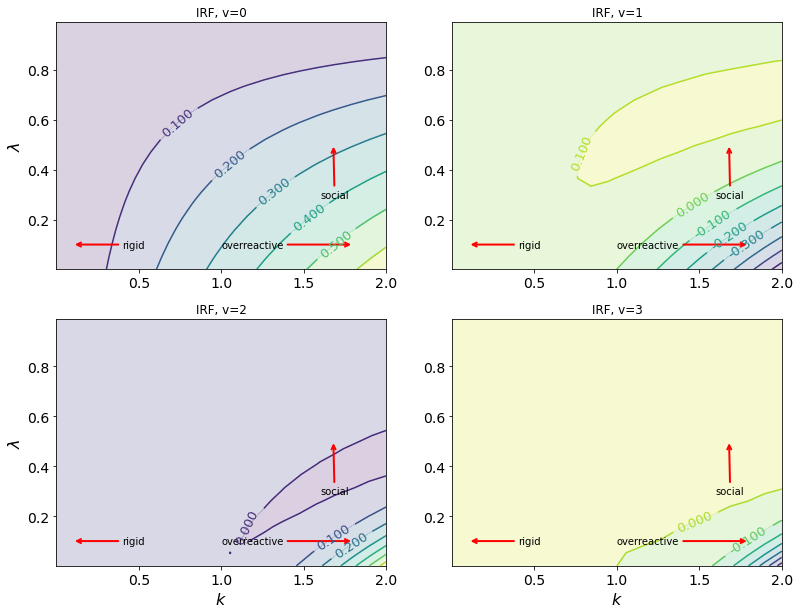

In [58]:
## plot 
#levels = np.array([0.0,0.1,0.2,0.3,0.4,0.5])

fig, ax = plt.subplots(2,2,figsize=(13,10))
ax = ax.ravel()


for v_id,v in enumerate(vs):
    this_IRF_ids = IRF_ids_ls[v_id]
    cs1 = ax[v_id].contourf(k_vals, λ_vals, this_IRF_ids.T, alpha=0.2)
    ctr1 = ax[v_id].contour(k_vals, λ_vals, this_IRF_ids.T)
    plt.clabel(ctr1, inline=2, fontsize=13)
    #plt.colorbar(cs1, ax=ax)
    ax[2].set_xlabel("$k$", fontsize=16)
    ax[3].set_xlabel("$k$", fontsize=16)
    ax[0].set_ylabel("$λ$", fontsize=16)
    ax[2].set_ylabel("$λ$", fontsize=16)
    ax[v_id].set_title(r'IRF, v={}'.format(v))

    ax[v_id].ticklabel_format(useOffset=False)

    ax[v_id].annotate('overreactive', xy=(1.8,0.1),
                xytext=(1.0,0.1), va='center', multialignment='right',
                arrowprops={'arrowstyle': '->', 'lw': 2, 'ec': 'r'})
    
    ax[v_id].annotate('rigid', xy=(0.1,0.1),
                xytext=(0.4,0.1), va='center', multialignment='right',
                arrowprops={'arrowstyle': '->', 'lw': 2, 'ec': 'r'})

    ax[v_id].annotate('social', xy=(1.68,0.5),
                xytext=(1.6,0.3), va='center', multialignment='right',
                arrowprops={'arrowstyle': '->', 'lw': 2, 'ec': 'r'})

plt.savefig('../graph/model/IRF_id_contourf.jpg')

#### Time path of IRF to local shocks to the top

In [79]:
k_fix = 1.5
k_vals = np.array([0.3,1,1.7])
λ_vals = np.array([0.01,0.3,0.8,0.99])
v_vals = np.arange(10)

In [80]:
IRF_id_path = np.empty((len(k_vals),len(λ_vals), len(v_vals)))
                       
for j,k in enumerate(k_vals):
    for i, λ in enumerate(λ_vals):
        for t, v in enumerate(v_vals):
            IRF_id_path[j,i,t] = irf_id_c(k=k,
                                          λ=λ,
                                          W=W,
                                          v=v,
                                          Z = Z_top)

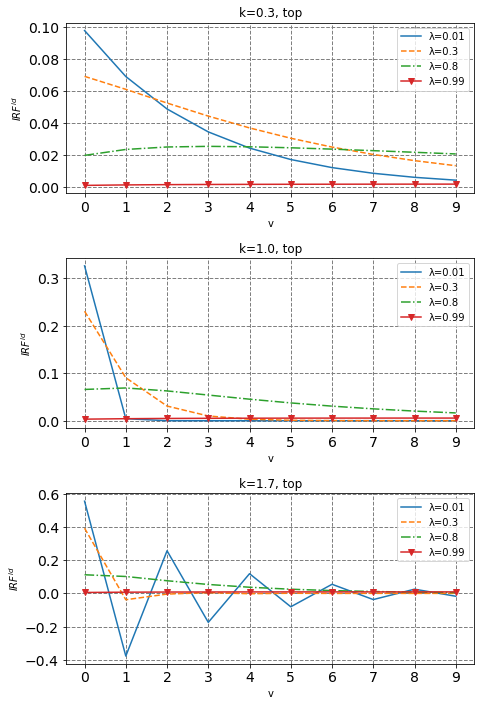

In [81]:
lp_ls=['-','--','-.','v-']
nb_plots = len(k_vals)
#b_lim =-0.1 ## y axis range lower lim
#t_lim = 0.6  ## y axis range upper lim

fig,ax =plt.subplots(nb_plots,1,figsize=(7,10))
ax = ax.ravel()

for j,k in enumerate(k_vals):
    for i,λ in enumerate(λ_vals):
        ax[j].plot(IRF_id_path[j,i,:],
                lp_ls[i],
               label =r'λ={}'.format(λ))
        ax[j].set_xlabel('v')
        ax[j].set_ylabel(r'$IRF^{id}$')
        ax[j].set_title(r'k={}, top'.format(k))
        ax[j].set_xticks(v_vals)
        ax[j].grid('major',color='gray', linestyle='--', linewidth=1)
        ax[j].legend(loc=0)
        #ax[j].set_ylim(b_lim, t_lim)
fig.tight_layout(pad=1.4)
plt.savefig('../graph/model/IRF_id_path_top.jpg')

#### Time path of IRF to local shocks to the bottom

In [82]:
k_fix = 1.5
k_vals = np.array([0.3,1,1.7])
λ_vals = np.array([0.01,0.3,0.8,0.99])
v_vals = np.arange(10)

IRF_id_path_bot = np.empty((len(k_vals),len(λ_vals), len(v_vals)))
                       
for j,k in enumerate(k_vals):
    for i, λ in enumerate(λ_vals):
        for t, v in enumerate(v_vals):
            IRF_id_path_bot[j,i,t] = irf_id_c(k=k,
                                          λ=λ,
                                          W=W,
                                          v=v,
                                          Z = Z_bot)

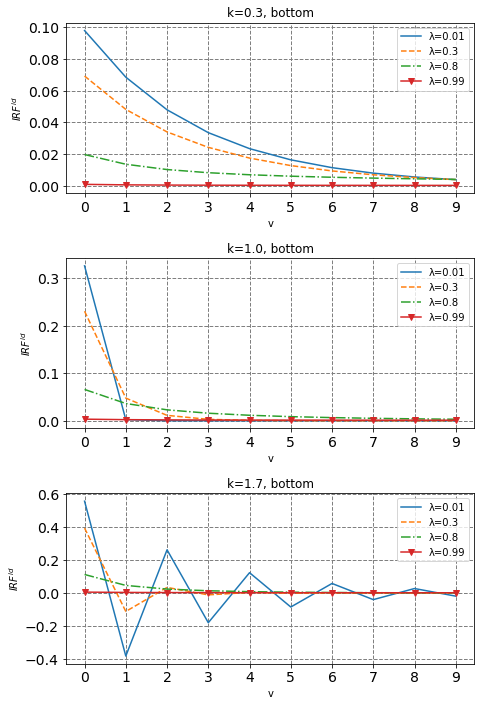

In [83]:
lp_ls=['-','--','-.','v-']
nb_plots = len(k_vals)

#b_lim =-0.3 ## y axis range lower lim
#t_lim = 0.6  ## y axis range upper lim

fig,ax =plt.subplots(nb_plots,1,figsize=(7,10))
ax = ax.ravel()

for j,k in enumerate(k_vals):
    for i,λ in enumerate(λ_vals):
        ax[j].plot(IRF_id_path_bot[j,i,:],
                lp_ls[i],
               label =r'λ={}'.format(λ))
        ax[j].set_xlabel('v')
        ax[j].set_ylabel(r'$IRF^{id}$')
        ax[j].set_title(r'k={}, bottom'.format(k))
        ax[j].set_xticks(v_vals)
        ax[j].grid('major',color='gray', linestyle='--', linewidth=1)
        ax[j].legend(loc=0)
        #ax[j].set_ylim(b_lim, t_lim)
fig.tight_layout(pad=1.4)
plt.savefig('../graph/model/IRF_id_path_bot.jpg')

### How does IRF depend on network structure 

In [ ]:
autarky = np.identity(N)
egal = np.ones((N,N))*1/N

In [ ]:
## different networks 
W_ls = [W,
        autarky,
        egal]
labels_ls =['Actual','Autarky','Egalitarian']

IRF_ids_ls=[]

## compute IRFs 

grid_size = 20

k_vals = np.linspace(0.001, 2.00, grid_size)
λ_vals = np.linspace(0.001, 0.99, grid_size)


for s,weigt in enumerate(W_ls):
    IRF_ids = np.empty((grid_size, grid_size))
    for i, k in enumerate(k_vals):
        for j, λ in enumerate(λ_vals):
            IRF_ids[i, j] = irf_id_c(k=k,
                                     λ=λ,
                                     W=weigt,
                                     v=1,
                                     Z = Z_top)
    # foreach weight matrix 
    IRF_ids_ls.append(IRF_ids)

In [ ]:
## plot 
fig, ax = plt.subplots(1,3,figsize=(18,5))

ax = ax.ravel()

for plt_id in range(len(W_ls)):
    IRF_ids_this = IRF_ids_ls[plt_id]
    cs1 = ax[plt_id].contourf(k_vals, λ_vals, IRF_ids_this.T, alpha=0.2)
    ctr1 = ax[plt_id].contour(k_vals, λ_vals, IRF_ids_this.T)


    ax[plt_id].set_title(str(labels_ls[plt_id]))
    ax[plt_id].set_xlabel("$k$", fontsize=16)
    ax[0].set_ylabel("$λ$", fontsize=16)

    ax[plt_id].ticklabel_format(useOffset=False)


    ax[plt_id].annotate('overreactive', xy=(1.8,0.1),
                xytext=(1.0,0.1), va='center', multialignment='right',
                arrowprops={'arrowstyle': '->', 'lw': 2, 'ec': 'r'})
    
    ax[plt_id].annotate('rigid', xy=(0.1,0.1),
                xytext=(0.4,0.1), va='center', multialignment='right',
                arrowprops={'arrowstyle': '->', 'lw': 2, 'ec': 'r'})

    ax[plt_id].annotate('social', xy=(1.68,0.5),
                xytext=(1.6,0.3), va='center', multialignment='right',
                arrowprops={'arrowstyle': '->', 'lw': 2, 'ec': 'r'})

plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)
plt.savefig('../graph/model/IRF_id_W_compare.jpg')

In [73]:
## time path 
Z_top_16 = where_to_shock(W16,
                          (0.0,0.33))

In [74]:
k_fix = 1.5
k_vals = np.array([0.3,1,1.7])
λ_vals = np.array([0.01,0.3,0.8,0.99])
v_vals = np.arange(10)

In [75]:
IRF_id_path_16 = np.empty((len(k_vals),len(λ_vals), len(v_vals)))
                       
for j,k in enumerate(k_vals):
    for i, λ in enumerate(λ_vals):
        for t, v in enumerate(v_vals):
            IRF_id_path_16[j,i,t] = irf_id_c(k=k,
                                             λ=λ,
                                             W=W16,
                                             v=v,
                                             Z = Z_top_16)
            

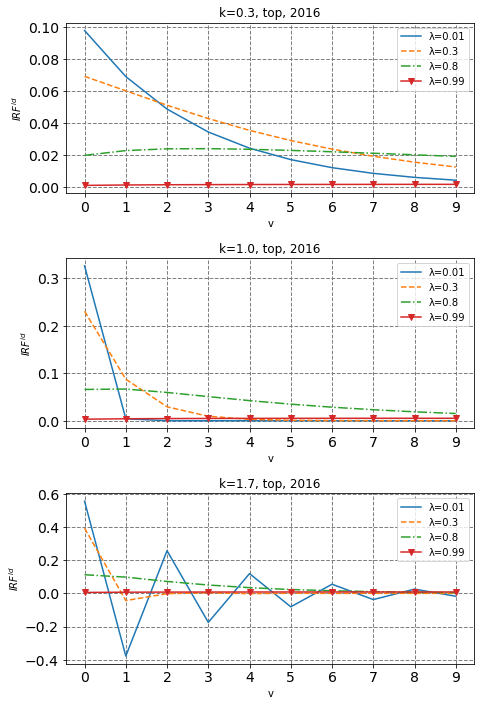

In [78]:
lp_ls=['-','--','-.','v-']
nb_plots = len(k_vals)
#b_lim =0.0 ## y axis range lower lim
#t_lim = 0.6  ## y axis range upper lim

fig,ax =plt.subplots(nb_plots,1,figsize=(7,10))
ax = ax.ravel()

for j,k in enumerate(k_vals):
    for i,λ in enumerate(λ_vals):
        ax[j].plot(IRF_id_path_16[j,i,:],
                lp_ls[i],
               label =r'λ={}'.format(λ))
        ax[j].set_xlabel('v')
        ax[j].set_ylabel(r'$IRF^{id}$')
        ax[j].set_title(r'k={}, top, 2016'.format(k))
        ax[j].set_xticks(v_vals)
        ax[j].grid('major',color='gray', linestyle='--', linewidth=1)
        ax[j].legend(loc=0)
        #ax[j].set_ylim(b_lim, t_lim)
fig.tight_layout(pad=1.4)
plt.savefig('../graph/model/IRF_id_path_top_2016.jpg')

### Estimation of the parameters

In [159]:
def kalman_ss(sigma_theta,
             sigma_eta):
    num = np.sqrt(sigma_theta**2+sigma_eta**2)*sigma_theta
    dem = num + sigma_theta**2+sigma_eta**2
    return num/dem 

In [169]:
k_ss = kalman_ss(ifp.a_psi,
                 sigma_eta)
print('steady state kalman kappa is + '+str(k_ss) )

steady state kalman kappa is + 0.33365586339387693


### Experiments and Counterfactuals

In [264]:
################################
## social network learning ##
###############################

def irf_b(ifp,
        p_vec,    ## price vector
        σ_,
        s_init,        ## initial bank balance distribution
        z_init,        ## initial z distribution
        z_jump = 0.5,  ## shock of z to some fraction of the agents in the economy 
        fraction = 1,
        period = 5,
        where = (0,1),        ## fraction of nodes to be shocked 
        weight = W,
        λ = 0.0,
        κ = 0.9):
    
    ## parameters 
    R = ifp.R
    z_val = ifp.z_val
    eps = ifp.eps
    
    ## simulate impulse responses 
    N = len(s_init)
    
    ## degrees 
    degree = np.sum(weight,axis = 0)
    rank_idx = np.flip(degree.argsort())  ## descending sorted index, e.g. the first element is the index of smallest influence
    lb,ub = where
    cut_lb,cut_ub = np.int(N*lb),np.int(N*ub),
    shocked_idx = rank_idx[cut_lb:cut_ub-1]  ### the index that to be shocked 
        
    ## aseet initial
    a_irf = np.empty((N,period))
    a_SS = np.empty((N,period))
    
    ## permanent income
    o_irf = np.empty((N,period))
    for n in range(N):
        n_burn = 10
        o_irf_burn = PerIncSimulate(period+n_burn,
                                sigma = ifp.a_p,
                                init = 0.00001)
        
        o_irf[n,:] = o_irf_burn[n_burn:]  ## burn the first 100 simulated observations  
    
    
    period_burn = period+1
    ## psi (aggregate) states
    psi_irf_burn = np.zeros(period_burn)
    psi_SS_burn = np.zeros(period_burn)
    
    ## z state initial
    
    z_SS_burn = np.tile(z_init,(period_burn,1)).T 
    z_irf_burn = np.copy(z_SS_burn)
    
    z_irf_burn_temp = z_irf_burn[:,1]  ## note here we let shock happens at time=1 not 0 to be able to compute surprises 
    z_irf_burn_temp[shocked_idx] = z_irf_burn_temp[shocked_idx]+z_jump  ## the shocked agents increase by z_jump
    z_irf_burn[:,1]= z_irf_burn_temp   ## update the initial history  
    
    for t in range(period_burn-2):
        z_irf_burn[:,t+2] = UpdateNextPeriod(z_irf_burn[:,t+1],
                                            1,
                                            psi_irf_burn[t+2],
                                            0)  ##  0 represents no further idiosyncratic shock
        
    for t in range(period_burn-2):
        z_SS_burn[:,t+2] = UpdateNextPeriod(z_SS_burn[:,t+1],
                                            1,
                                            psi_SS_burn[t+2],
                                            0) 
    z_SS = z_SS_burn[:,1:]  ## the shock happens at t=1 for burn matrix but we want to plot it at t=0
    z_irf = z_irf_burn[:,1:] ## same as above 
       
        
    ## gains 
    κ_mat = κ*np.ones((N,N))
    
    
    ## surprises 
    s_irf = z_irf_burn[:,1:]-  z_irf_burn[:,:-1]
    s_SS = z_SS_burn[:,1:]-  z_SS_burn[:,:-1]
    
    ## psi belief state initial
    psi_b_irf = UpdateBeliefDistFromVal(s_irf,
                                        W,
                                        κ_mat,
                                        λ)
    #psi_b_irf = psi_b_irf_burn[:,:] ## drop the first period because it does not updated based on surprises
    
    psi_b_SS = UpdateBeliefDistFromVal(s_SS,
                                       W,
                                       κ_mat,
                                       λ)
    #psi_b_SS = psi_b_SS_burn[:,:]
    ## simulate shocks
    ζ_sim = np.random.randn(N,period)-1/2
    η_sim = np.random.randn(N,period)-1/2
    
    ## consumption responses 
    c_irf = np.empty((N,period))
    c1_irf = np.empty((N,period))
    c2_irf = np.empty((N,period))
    c_SS = np.empty((N,period))
    c1_SS = np.empty((N,period))
    c2_SS = np.empty((N,period))
    
    
    ## update initial asset/consumption
    for n in range(N):
        ## irf 
        z = z_irf[n,0]      ## idiosyncratic state 
        S = ifp.ϕ(z,ζ_sim[n,0])  ## preference hsock depends on believed state 
        Y = ifp.Y(z, η_sim[n,0]) ## income depends on true state 
        a = s_init[n]+ Y   
        a_irf[n,0] = a 
        zpsi = z + psi_b_irf[n,0]
        c_irf[n,0] = σ_(a,zpsi)  ## consumption depends on the perceived state 
        c1_irf[n,0],c2_irf[n,0] = allocate(c_irf[n,0],
                                           eps = eps,
                                           S=S)
        
        ## SS
        z = z_SS[n,0]       ## idiosyncratic state 
        S = ifp.ϕ(z,ζ_sim[n,0])  ## preference hsock depends on believed state 
        Y = ifp.Y(z, η_sim[n,0]) ## income depends on true state 
        a = s_init[n]+ Y   ## consumption depends on the perceived state 
        a_SS[n,0] = a 
        zpsi = z+ psi_b_SS[n,0]
        c_SS[n,0] = σ_(a,zpsi)
        c1_SS[n,0],c2_SS[n,0] = allocate(c_SS[n,0],
                                         eps = eps,
                                         S = S)
    
    ## fill the rest of the histories  
    for n in range(N):
        Γs = o_irf[n,1:]/o_irf[n,:-1] 
        for t in range(period-1):
            ## irf
            z = z_irf[n,t+1]  ## idiosyncratic state 
            S = ifp.ϕ(z,ζ_sim[n,t+1])  ## preference shock depends on believed state 
            Y = ifp.Y(z, η_sim[n,t+1]) ## perception goes to the consumption decision
            a = a_irf[n,t]  ## truth goes to law of motion
            a_irf[n,t+1] = R/Γs[t] * (a - c1_irf[n,t]*p_vec[0]-c2_irf[n,t]*p_vec[1]) + Y  
            a_new  = a_irf[n,t+1]
            zpsi = z+ psi_b_irf[n,t+1]
            c_irf[n,t+1] = σ_(a_new,zpsi)
            c1_irf[n,t+1],c2_irf[n,t+1] = allocate(c_irf[n,t+1], 
                                                   eps = eps,
                                                   S=S)
            
            ## SS
            z = z_SS[n,t+1]
            S = ifp.ϕ(z,ζ_sim[n,t+1])  ## preference shock depends on believed state 
            Y = ifp.Y(z, η_sim[n,t+1])
            a = a_SS[n,t]
            a_SS[n,t+1] = R/Γs[t] * (a - c1_SS[n,t]*p_vec[0]-c2_SS[n,t]*p_vec[1]) + Y
            a_new  = a_SS[n,t+1]
            zpsi = z+ psi_b_SS[n,t+1]
            c_SS[n,t+1] = σ_(a_new,zpsi)
            c1_SS[n,t+1],c2_SS[n,t+1] = allocate(c_SS[n,t+1], 
                                                 eps = eps,
                                                 S = S)
            
    
    ## multiply asset/consumption by permanent income level 
    #c_irf= np.multiply(c_irf,o_irf)
    #c1_irf = np.multiply(c1_irf,o_irf)
    #c2_irf = np.multiply(c2_irf,o_irf)
    #a_irf = np.multiply(a_irf,o_irf) 
    #c_SS = np.multiply(c_SS,o_irf)
    #c1_SS = np.multiply(c1_SS,o_irf)
    #c2_SS = np.multiply(c2_SS,o_irf)
    #a_SS = np.multiply(a_SS,o_irf) 
     
    
    ## get the cross-sectional average 
    z_irf,psi_b_irf = np.mean(z_irf,axis=0),np.mean(psi_b_irf,axis=0)
    c_irf, c1_irf,c2_irf = np.mean(np.log(c_irf),axis=0), np.mean(np.log(c1_irf),axis=0),np.mean(np.log(c2_irf),axis=0)
    a_irf = np.mean(np.log(a_irf), axis=0)  
    
    z_SS,psi_b_SS = np.mean(z_SS,axis=0),np.mean(psi_b_SS,axis=0)
    c_SS, c1_SS,c2_SS = np.mean(np.log(c_SS),axis=0), np.mean(np.log(c1_SS),axis=0),np.mean(np.log(c2_SS),axis=0) 
    a_SS = np.mean(np.log(a_SS), axis=0)
    
    return z_irf, psi_b_irf, a_irf, c_irf, c1_irf, c2_irf, z_SS, psi_b_SS, a_SS, c_SS, c1_SS, c2_SS

In [265]:
## steady state asset and states 
s_SS_init = a_dist[:,-1]-c_dist[:,-1]
N = s_SS_init.shape[0]
z_SS_init = z_ss_av*np.ones(N)

In [266]:
## get the impulse responses

z_irf,psi_b_irf,a_irf, c_irf, c1_irf,c2_irf,z_SS,psi_b_SS,a_SS, c_SS, c1_SS,c2_SS = irf_b(ifp,
                                                                                    p_vec,
                                                                                    σ_,
                                                                                    s_SS_init,
                                                                                    z_SS_init,
                                                                                    z_jump = 0.1,
                                                                                    where = (0,0.33),
                                                                                    period = 20,
                                                                                    weight = W,
                                                                                    λ = 0.9,
                                                                                    κ = k_ss)

<ipython-input-263-518d52f9a54f>:11: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  belief_vec_post = M@belief_vec_prior+ (1-λ)*np.diag(H-κ)@s
/Users/Myworld/anaconda3/lib/python3.7/site-packages/numba/typing/npydecl.py:958: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


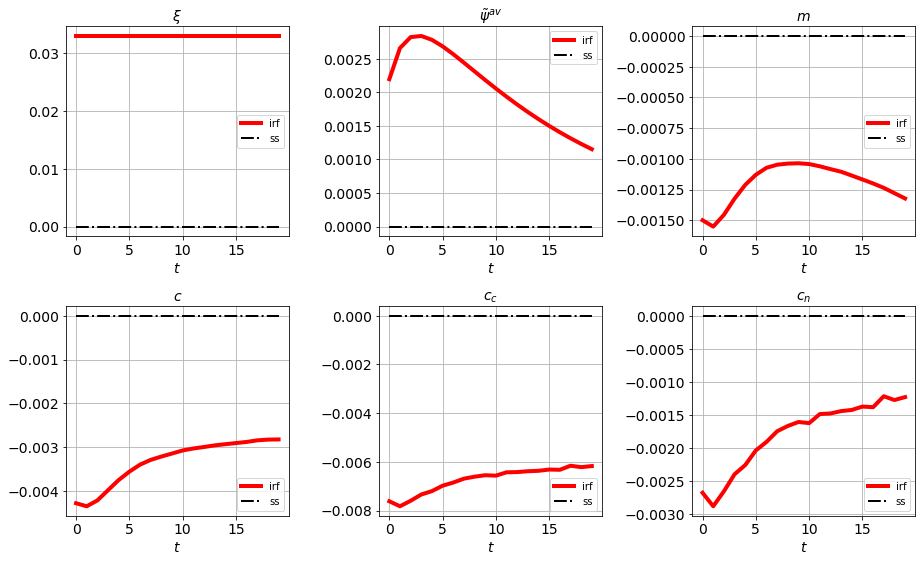

In [267]:
## plot impulses reponses

fig, axs = plt.subplots(2,3, 
                        figsize=(13, 8), 
                        facecolor='w', 
                        edgecolor='k')

irf_plot = [z_irf, psi_b_irf, a_irf, c_irf, c1_irf,c2_irf]
ss_plot =  [z_SS, psi_b_SS, a_SS, c_SS, c1_SS,c2_SS]

names = [r'$\xi$',r'$\tilde \psi^{av}$',r'$m$',r'$c$',r'$c_c$',r'$c_n$']

axs = axs.ravel()

for i, var in enumerate(irf_plot):
    compared_to_SS = var- ss_plot[i]  ## plot the relative differences with SS
    rebase_SS = np.zeros(len(var))    ## set SS to be zero
    axs[i].plot(compared_to_SS,
                'r-',
                lw = 4,
               label = 'irf')
    axs[i].plot(rebase_SS,
               'k-.',
               lw = 2,
               label ='ss')
    axs[i].set_title(names[i], fontsize=fontsize)
    axs[i].set_xlabel(r'$t$',fontsize = fontsize)
    axs[i].legend(loc= 0)
    axs[i].set_xticks(np.array([0,5,10,15]))
    axs[i].grid()
fig.tight_layout(pad=1.4)

### IRF w/o social learning

- $\lambda$ = 1/0

In [ ]:
## no social learning

## get the impulse responses when there is no social network influence 
z_irf0,psi_b_irf0,a_irf0, c_irf0, c1_irf0,c2_irf0,z_SS0,psi_b_SS0,a_SS0, c_SS0, c1_SS0,c2_SS0 = irf_b(ifp,
                                                                                                  p_vec,
                                                                                                  σ_,
                                                                                                  s_SS_init,
                                                                                                  z_SS_init,
                                                                                                  z_jump = 0.1,
                                                                                                  where = (0,0.33),
                                                                                                  period = 20,
                                                                                                  weight = W,
                                                                                                  λ = 0.0,
                                                                                                  κ = 0.3)

In [ ]:
## plot impulses reponses

fig, axs = plt.subplots(2,
                        3, 
                        figsize=(13, 8), 
                        facecolor='w', 
                        edgecolor='k')

irf0_plot = [z_irf0, psi_b_irf0, a_irf0, c_irf0, c1_irf0,c2_irf0]
ss0_plot =  [z_SS0, psi_b_SS0, a_SS0, c_SS0, c1_SS0,c2_SS0]

irf_plot = [z_irf, psi_b_irf, a_irf, c_irf, c1_irf,c2_irf]
ss_plot =  [z_SS, psi_b_SS, a_SS, c_SS, c1_SS,c2_SS]

names = [r'$\xi$',r'$\tilde \psi$',r'$m$',r'$c$',r'$c_c$',r'$c_n$']


axs = axs.ravel()

for i, var in enumerate(irf_plot):
    ## with social network 
    compared_to_SS = var- ss_plot[i]  ## plot the relative differences with SS
    rebase_SS = np.zeros(len(var))    ## set SS to be zero
    
    compared_to_SS0 = irf0_plot[i]- ss0_plot[i]  ## plot the relative differences with SS
    rebase_SS0 = np.zeros(len(var))    ## set SS to be zero
    
    axs[i].plot(compared_to_SS,
                'r-',
                lw = 4,
               label = 'irf (with social learning)')
    #axs[i].plot(rebase_SS,
    #          '-.',
    #           lw = 2,
    #           label ='ss')
    # without social network 
    axs[i].plot(compared_to_SS0,
               'b-.',
               lw = 4,
               label ='irf (no social learning)')
    #axs[i].plot(rebase_SS0,
    #           '-.',
    #           lw = 2,
    #           label ='ss (no network)')
        
    axs[i].set_title(names[i], fontsize=fontsize)
    axs[i].set_xlabel(r'$t$', fontsize=fontsize)
    axs[i].legend(loc= 0)
    axs[i].grid()
fig.tight_layout(pad=1.4)
plt.savefig('../graph/model/irf_social_new.jpg')

### IRF with different degrees of social influence

- different $\lambda$s

In [268]:
λ_s = [0.0,
       0.4,
       0.9
      ]

z_irf_list, psi_b_irf_list, a_irf_list, c_irf_list, c1_irf_list,c2_irf_list = [],[],[],[],[],[]
z_SS_list, psi_b_SS_list, a_SS_list, c_SS_list, c1_SS_list,c2_SS_list = [],[],[],[],[],[]


for i,λ_this in enumerate(λ_s):
    ## get the impulse responses
    #k_this = 0.15/(1-λ_this)
    #print(k_this)
    print((1/3*(1-λ_this)*k_ss))
    z_irf,psi_b_irf,a_irf, c_irf, c1_irf,c2_irf,z_SS,psi_b_SS,a_SS, c_SS, c1_SS,c2_SS = irf_b(ifp,
                                                                                        p_vec,
                                                                                        σ_,
                                                                                        s_SS_init,
                                                                                        z_SS_init,
                                                                                        z_jump = 0.1,
                                                                                        where = (0,0.33),
                                                                                        period = 20,
                                                                                        weight = W,
                                                                                        λ = λ_this,
                                                                                        κ = k_ss) 
    z_irf_list.append(z_irf)
    psi_b_irf_list.append(psi_b_irf)
    a_irf_list.append(a_irf)
    c_irf_list.append(c_irf)
    c1_irf_list.append(c1_irf)
    c2_irf_list.append(c2_irf)
    
    z_SS_list.append(z_SS)
    psi_b_SS_list.append(psi_b_SS)
    a_SS_list.append(a_SS)
    c_SS_list.append(c_SS)
    c1_SS_list.append(c1_SS)
    c2_SS_list.append(c2_SS)

0.1112186211312923
0.06673117267877537
0.011121862113129228


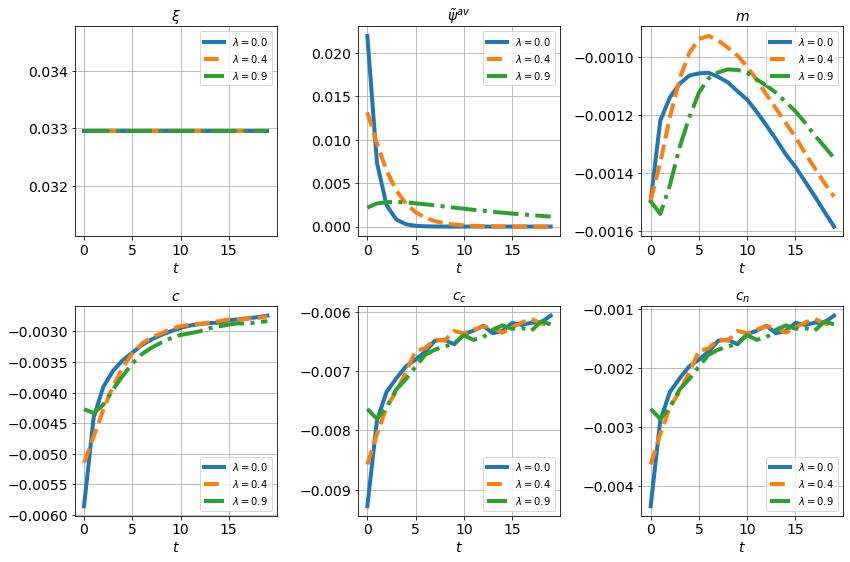

In [269]:
## plot impulses reponses

fig, axs = plt.subplots(2,3, 
                        figsize=(12, 8), 
                        facecolor='w', 
                        edgecolor='k')

irf_list_plot = [z_irf_list, psi_b_irf_list, a_irf_list, c_irf_list, c1_irf_list,c2_irf_list]
#ss_plot =  [z_SS, z_b_SS, a_SS, c_SS, c1_SS,c2_SS]
ss_list_plot = [z_SS_list, psi_b_SS_list, a_SS_list, c_SS_list, c1_SS_list,c2_SS_list]


names = [r'$\xi$',r'$\tilde \psi^{av}$',r'$m$',r'$c$',r'$c_c$',r'$c_n$']
lps = ['-','--','-.']



axs = axs.ravel()

for i, var in enumerate(irf_list_plot):
    for s in range(len(λ_s)):
        compared_to_SS = var[s]- ss_list_plot[i][s]  ## plot the relative differences with SS
        rebase_SS = np.zeros(len(var[s]))    ## set SS to be zero
        axs[i].plot(compared_to_SS,
                    lps[s],
                    lw = 4,
                   label = r'$\lambda={}$'.format(λ_s[s]))
    #axs[i].plot(rebase_SS,
    #           'r-.',
    #           lw = 2,
    #           label ='ss')
    axs[i].set_title(names[i],fontsize=fontsize)
    axs[i].set_xlabel(r'$t$',fontsize=fontsize)
    axs[i].legend(loc= 0)
    axs[i].set_xticks(np.array([0,5,10,15]))
    axs[i].grid('major')
fig.tight_layout(pad=1.4)
plt.savefig('../graph/model/irf_social.jpg')

### IRF with different degrees of belief rigidity

- different $\kappa$s

In [210]:
κ_s = [0.1,
       0.6,
       1.1]

z_irf_list, psi_b_irf_list, a_irf_list, c_irf_list, c1_irf_list,c2_irf_list = [],[],[],[],[],[]
z_SS_list, psi_b_SS_list, a_SS_list, c_SS_list, c1_SS_list,c2_SS_list = [],[],[],[],[],[]


for i,κ_this in enumerate(κ_s):
    ## get the impulse responses
    λ_this = 1-0.15/κ_this
    print(λ_this)
    z_irf,psi_b_irf,a_irf, c_irf, c1_irf,c2_irf,z_SS,psi_b_SS,a_SS, c_SS, c1_SS,c2_SS = irf_b(ifp,
                                                                                        p_vec,
                                                                                        σ_,
                                                                                        s_SS_init,
                                                                                        z_SS_init,
                                                                                        z_jump = 0.1,
                                                                                        where = (0,0.33),
                                                                                        period = 20,
                                                                                        weight = W,
                                                                                        λ = λ_this,
                                                                                        κ = κ_this) 
    z_irf_list.append(z_irf)
    psi_b_irf_list.append(psi_b_irf)
    a_irf_list.append(a_irf)
    c_irf_list.append(c_irf)
    c1_irf_list.append(c1_irf)
    c2_irf_list.append(c2_irf)
    
    z_SS_list.append(z_SS)
    psi_b_SS_list.append(psi_b_SS)
    a_SS_list.append(a_SS)
    c_SS_list.append(c_SS)
    c1_SS_list.append(c1_SS)
    c2_SS_list.append(c2_SS)

-0.4999999999999998
0.75
0.8636363636363636


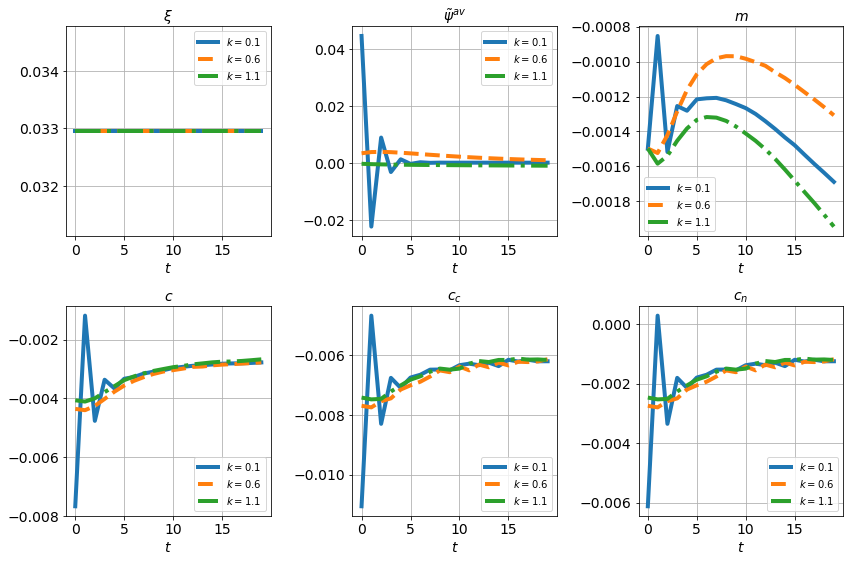

In [211]:
## plot impulse reponses

fig, axs = plt.subplots(2,3, 
                        figsize=(12, 8), 
                        facecolor='w', 
                        edgecolor='k')

irf_list_plot = [z_irf_list, psi_b_irf_list, a_irf_list, c_irf_list, c1_irf_list,c2_irf_list]
#ss_plot =  [z_SS, z_b_SS, a_SS, c_SS, c1_SS,c2_SS]
ss_list_plot = [z_SS_list, psi_b_SS_list, a_SS_list, c_SS_list, c1_SS_list,c2_SS_list]


names = [r'$\xi$',r'$\tilde \psi^{av}$',r'$m$',r'$c$',r'$c_c$',r'$c_n$']
lps = ['-','--','-.']



axs = axs.ravel()

for i, var in enumerate(irf_list_plot):
    for s in range(len(κ_s)):
        compared_to_SS = var[s]- ss_list_plot[i][s]  ## plot the relative differences with SS
        rebase_SS = np.zeros(len(var[s]))    ## set SS to be zero
        axs[i].plot(compared_to_SS,
                    lps[s],
                    lw = 4,
                   label = r'$k={}$'.format(κ_s[s]))
    #axs[i].plot(rebase_SS,
    #           'r-.',
    #           lw = 2,
    #           label ='ss')
    axs[i].set_title(names[i],fontsize=fontsize)
    axs[i].set_xlabel(r'$t$',fontsize=fontsize)
    axs[i].legend(loc= 0)
    axs[i].set_xticks(np.array([0,5,10,15]))
    axs[i].grid()
fig.tight_layout(pad=1.4)
plt.savefig('../graph/model/irf_private.jpg')

### IRF in corner scenarios 

|                                         | $\lambda$ = 0      | 0<$\lambda$ <1       | $\lambda$ =1            |   |
|-----------------------------------------|--------------------|----------------------|-------------------------|---|
| $k>\kappa^*$                            | extrapolative/heedless | extrapolative/communicative | extrapolative/credulous |   |
| $k=1$                        | fickle/heedless        | fickle/communicative        | fickle/credulous        |   |
| $k=\kappa^*$ dynamically adjusted | rational/heedless      | rational/communicative      | rational/credulous      |   |
| $k=0$                              | rigid/heedless         | rigid/communicative         | rigid/credulous         |   |

In [ ]:
κ_λ_s = [#[1.1,0.0],
         #[1.1,1.0],
         [1.0,0.0],
         [1.0,1.0],
         [0.0,0.0],
         [0.0,1.0]
        ]


z_irf_list, psi_b_irf_list, a_irf_list, c_irf_list, c1_irf_list,c2_irf_list = [],[],[],[],[],[]
z_SS_list, psi_b_SS_list, a_SS_list, c_SS_list, c1_SS_list,c2_SS_list = [],[],[],[],[],[]


for i,κ_λ_this in enumerate(κ_λ_s):
    κ_this,λ_this = κ_λ_this
    ## get the impulse responses
    z_irf,psi_b_irf,a_irf, c_irf, c1_irf,c2_irf,z_SS,psi_b_SS,a_SS, c_SS, c1_SS,c2_SS = irf_b(ifp,
                                                                                        p_vec,
                                                                                        σ_,
                                                                                        s_SS_init,
                                                                                        z_SS_init,
                                                                                        z_jump = 0.1,
                                                                                        where = (0,0.33),
                                                                                        period = 20,
                                                                                        weight = W,
                                                                                        λ = λ_this,
                                                                                        κ = κ_this) 
    z_irf_list.append(z_irf)
    psi_b_irf_list.append(psi_b_irf)
    a_irf_list.append(a_irf)
    c_irf_list.append(c_irf)
    c1_irf_list.append(c1_irf)
    c2_irf_list.append(c2_irf)
    
    z_SS_list.append(z_SS)
    psi_b_SS_list.append(psi_b_SS)
    a_SS_list.append(a_SS)
    c_SS_list.append(c_SS)
    c1_SS_list.append(c1_SS)
    c2_SS_list.append(c2_SS)

In [ ]:
## plot impulses reponses

fig, axs = plt.subplots(2,3, 
                        figsize=(12, 8), 
                        facecolor='w', 
                        edgecolor='k')

irf_list_plot = [z_irf_list, psi_b_irf_list, a_irf_list, c_irf_list, c1_irf_list,c2_irf_list]
#ss_plot =  [z_SS, z_b_SS, a_SS, c_SS, c1_SS,c2_SS]
ss_list_plot = [z_SS_list, psi_b_SS_list, a_SS_list, c_SS_list, c1_SS_list,c2_SS_list]

labels = [#'CD',
          #'CC',
          'RH',
          'RC',
          'FH',
          'FC'
         ]

names = [r'$\xi$',r'$\tilde \psi^{av}$',r'$m$',r'$c$',r'$c_c$',r'$c_n$']
lps = ['-',
       '--',
       '-.',
       '-*',
       #'*',
       #'v'
      ]

axs = axs.ravel()

for i, var in enumerate(irf_list_plot):
    for s in range(len(κ_λ_s)):
        compared_to_SS = var[s]- ss_list_plot[i][s]  ## plot the relative differences with SS
        rebase_SS = np.zeros(len(var[s]))    ## set SS to be zero
        axs[i].plot(compared_to_SS,
                    lps[s],
                    lw = 4,
                   label = labels[s])
    #axs[i].plot(rebase_SS,
    #           'r-.',
    #           lw = 2,
    #           label ='ss')
    axs[i].set_title(names[i],fontsize=fontsize)
    axs[i].set_xlabel(r'$t$',fontsize=fontsize)
    axs[i].legend(loc= 0)
    axs[i].grid()
fig.tight_layout(pad=1.4)
plt.savefig('../graph/model/irf_four_extremes_new.jpg')

### IRF depending on where the shocks hit 

In [198]:
wheres = [(0,0.33),
         (0.33,0.66),
        (0.66,0.99)
         ]
z_irf_list, psi_b_irf_list, a_irf_list, c_irf_list, c1_irf_list,c2_irf_list = [],[],[],[],[],[]
z_SS_list, psi_b_SS_list, a_SS_list, c_SS_list, c1_SS_list,c2_SS_list = [],[],[],[],[],[]


for i,where in enumerate(wheres):
    ## get the impulse responses
    z_irf,psi_b_irf,a_irf, c_irf, c1_irf,c2_irf,z_SS,psi_b_SS,a_SS, c_SS, c1_SS,c2_SS = irf_b(ifp,
                                                                                        p_vec,
                                                                                        σ_,
                                                                                        s_SS_init,
                                                                                        z_SS_init,
                                                                                        z_jump = 0.1,
                                                                                        where = where,
                                                                                        period = 20,
                                                                                        weight = W,
                                                                                        λ = 0.7,
                                                                                        κ = k_ss) 
    z_irf_list.append(z_irf)
    psi_b_irf_list.append(psi_b_irf)
    a_irf_list.append(a_irf)
    c_irf_list.append(c_irf)
    c1_irf_list.append(c1_irf)
    c2_irf_list.append(c2_irf)
    
    z_SS_list.append(z_SS)
    psi_b_SS_list.append(psi_b_SS)
    a_SS_list.append(a_SS)
    c_SS_list.append(c_SS)
    c1_SS_list.append(c1_SS)
    c2_SS_list.append(c2_SS)

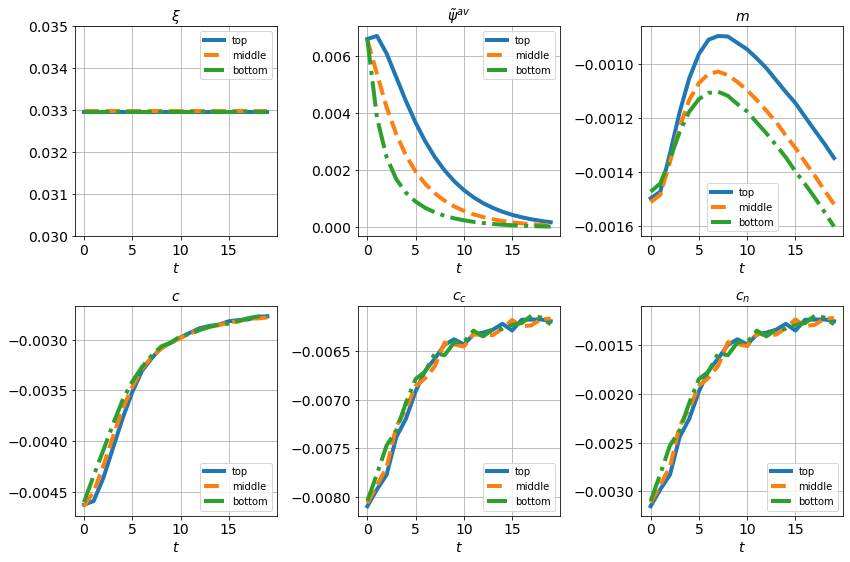

In [204]:
## plot impulses reponses

labels = ['top','middle','bottom']

fig, axs = plt.subplots(2,3, 
                        figsize=(12, 8), 
                        facecolor='w', 
                        edgecolor='k')

irf_list_plot = [z_irf_list, psi_b_irf_list, a_irf_list, c_irf_list, c1_irf_list,c2_irf_list]
ss_list_plot = [z_SS_list, psi_b_SS_list, a_SS_list, c_SS_list, c1_SS_list,c2_SS_list]

names = [r'$\xi$',r'$\tilde \psi^{av}$',r'$m$',r'$c$',r'$c_c$',r'$c_n$']
lps = ['-','--','-.']



axs = axs.ravel()

for i, var in enumerate(irf_list_plot):
    for s in range(len(labels)):
        compared_to_SS = var[s]- ss_list_plot[i][s]  ## plot the relative differences with SS
        rebase_SS = np.zeros(len(var[s]))    ## set SS to be zero
        axs[i].plot(compared_to_SS,
                    lps[s],
                    lw = 4,
                   label = labels[s])
    #axs[i].plot(rebase_SS,
    #           'r-.',
    #           lw = 2,
    #           label ='ss')
    axs[i].set_title(names[i],fontsize=fontsize)
    axs[i].set_xlabel(r'$t$',fontsize=fontsize)
    axs[i].legend(loc= 0)
    axs[0].set_ylim(0.03,0.035)
    axs[i].set_xticks(np.array([0,5,10,15]))
    axs[i].grid()
fig.tight_layout(pad=1.4)
plt.savefig('../graph/model/irf_where.jpg')

### IRF depending on the EOS

In [194]:
eps_vals = np.array([0.75,0.98,1.5])

z_irf_list, psi_b_irf_list, a_irf_list, c_irf_list, c1_irf_list,c2_irf_list = [],[],[],[],[],[]
z_SS_list, psi_b_SS_list, a_SS_list, c_SS_list, c1_SS_list,c2_SS_list = [],[],[],[],[],[]


for i,eps in enumerate(eps_vals):
    ifp.eps  = eps 
    z_irf,psi_b_irf,a_irf, c_irf, c1_irf,c2_irf,z_SS,psi_b_SS,a_SS, c_SS, c1_SS,c2_SS = irf_b(ifp,
                                                                                        p_vec,
                                                                                        σ_,
                                                                                        s_SS_init,
                                                                                        z_SS_init,
                                                                                        z_jump = 0.1,
                                                                                        where = (0,0.33),
                                                                                        period = 20,
                                                                                        weight = W,
                                                                                        λ = 0.5,
                                                                                        κ = k_ss)
    z_irf_list.append(z_irf) 
    psi_b_irf_list.append(psi_b_irf)
    a_irf_list.append(a_irf)
    c_irf_list.append(c_irf)
    c1_irf_list.append(c1_irf)
    c2_irf_list.append(c2_irf)
    
    z_SS_list.append(z_SS) 
    psi_b_SS_list.append(psi_b_SS)
    a_SS_list.append(a_SS)
    c_SS_list.append(c_SS)
    c1_SS_list.append(c1_SS)
    c2_SS_list.append(c2_SS)

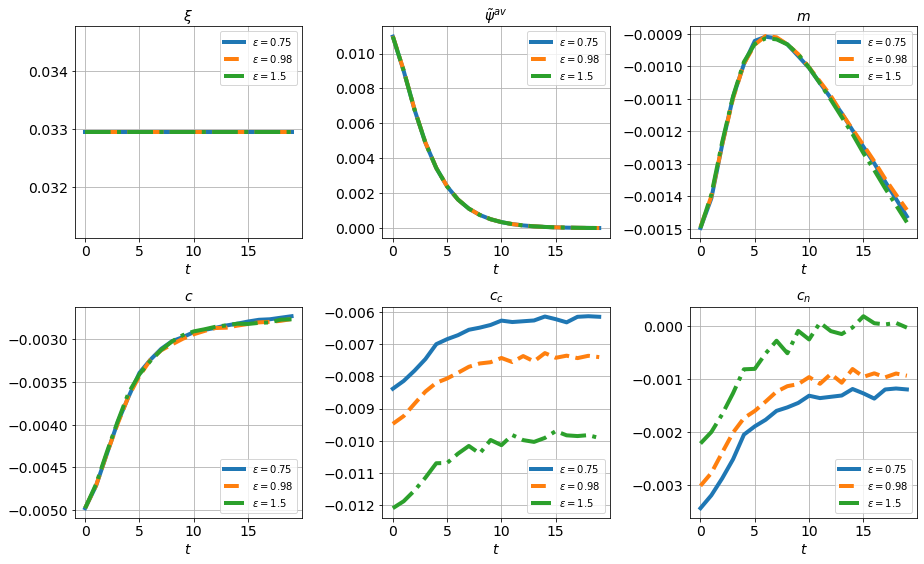

In [195]:
## plot impulses reponses


fig, axs = plt.subplots(2,3, 
                        figsize=(13, 8), 
                        facecolor='w', 
                        edgecolor='k')

irf_list_plot = [z_irf_list, psi_b_irf_list, a_irf_list, c_irf_list, c1_irf_list,c2_irf_list]
ss_list_plot = [z_SS_list, psi_b_SS_list, a_SS_list, c_SS_list, c1_SS_list,c2_SS_list]


names = [r'$\xi$',r'$\tilde \psi^{av}$',r'$m$',r'$c$',r'$c_c$',r'$c_n$']
lps = ['-','--','-.']



axs = axs.ravel()

for i, var in enumerate(irf_list_plot):
    for s,eps in enumerate(eps_vals):
        compared_to_SS = var[s]- ss_list_plot[i][s]  ## plot the relative differences with SS
        rebase_SS = np.zeros(len(var[s]))    ## set SS to be zero
        axs[i].plot(compared_to_SS,
                    lps[s],
                    lw = 4,
                   label = r'$\epsilon={}$'.format(eps))
        axs[i].set_title(names[i],fontsize=fontsize)
        axs[i].set_xlabel(r'$t$',fontsize=fontsize)
        axs[i].legend(loc= 0)
        axs[i].set_xticks(np.array([0,5,10,15]))
        axs[i].grid()
        
fig.tight_layout(pad=1.3)
plt.savefig('../graph/model/irf_eos.jpg')

### IRF of different social network structure 

In [196]:
## weight matrix 

## Identity matrix 

Identity = np.eye(N)  ## no social network is when the weight matrix takes an identity matrix

W_list = [Identity,W,W16]

z_irf_list, psi_b_irf_list, a_irf_list, c_irf_list, c1_irf_list,c2_irf_list = [],[],[],[],[],[]
z_SS_list, psi_b_SS_list, a_SS_list, c_SS_list, c1_SS_list,c2_SS_list = [],[],[],[],[],[]

ifp.eps = 0.75

for i,wt_mat in enumerate(W_list):
    ## nb of agents differ in 2016 and 2019
    ## need to adjust the matrix size 
    N_now = wt_mat.shape[0]    
    ss_SS_init_now = s_SS_init[0:N_now-1]
    z_SS_init_now = z_SS_init[0:N_now-1]
    
    # generate impulse responses 
    z_irf,psi_b_irf,a_irf, c_irf, c1_irf,c2_irf,z_SS,psi_b_SS,a_SS, c_SS, c1_SS,c2_SS = irf_b(ifp,
                                                                                        p_vec,
                                                                                        σ_,
                                                                                        s_SS_init,
                                                                                        z_SS_init,
                                                                                        z_jump = 0.1,
                                                                                        where = (0,0.33),
                                                                                        period = 20,
                                                                                        weight = wt_mat,
                                                                                        λ = 0.3,
                                                                                        κ = k_ss)
    z_irf_list.append(z_irf) 
    psi_b_irf_list.append(psi_b_irf)
    a_irf_list.append(a_irf)
    c_irf_list.append(c_irf)
    c1_irf_list.append(c1_irf)
    c2_irf_list.append(c2_irf)
    
    z_SS_list.append(z_SS) 
    psi_b_SS_list.append(psi_b_SS)
    a_SS_list.append(a_SS)
    c_SS_list.append(c_SS)
    c1_SS_list.append(c1_SS)
    c2_SS_list.append(c2_SS)

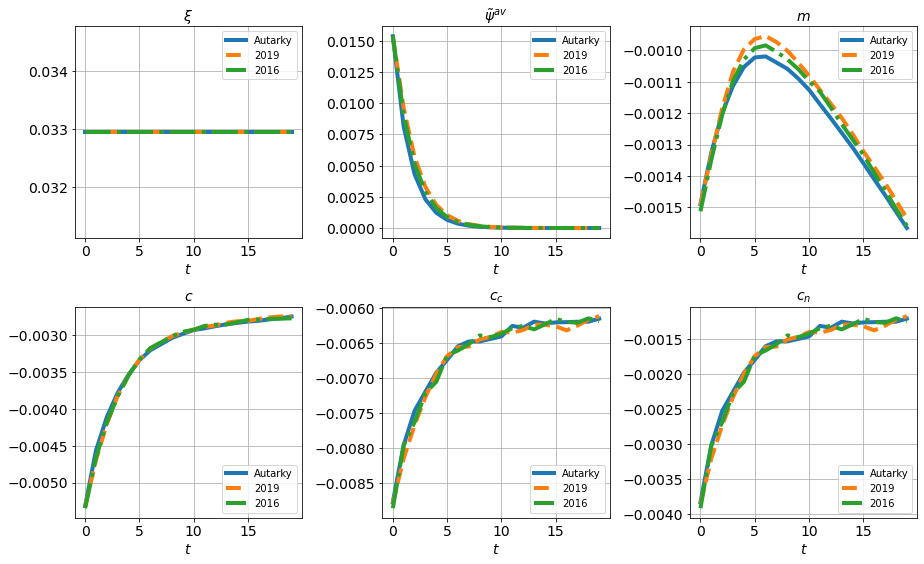

In [197]:
## plot impulses reponses


fig, axs = plt.subplots(2,3, 
                        figsize=(13, 8), 
                        facecolor='w', 
                        edgecolor='k')

irf_list_plot = [z_irf_list, psi_b_irf_list, a_irf_list, c_irf_list, c1_irf_list,c2_irf_list]
ss_list_plot = [z_SS_list, psi_b_SS_list, a_SS_list, c_SS_list, c1_SS_list,c2_SS_list]


names = [r'$\xi$',r'$\tilde \psi^{av}$',r'$m$',r'$c$',r'$c_c$',r'$c_n$']
lps = ['-','--','-.']
w_names = ['Autarky','2019','2016']


axs = axs.ravel()

for i, var in enumerate(irf_list_plot):
    for s,wt_mat in enumerate(W_list):
        compared_to_SS = var[s]- ss_list_plot[i][s]  ## plot the relative differences with SS
        rebase_SS = np.zeros(len(var[s]))    ## set SS to be zero
        axs[i].plot(compared_to_SS,
                    lps[s],
                    lw = 4,
                   label = w_names[s])
        axs[i].set_title(names[i],fontsize=fontsize)
        axs[i].set_xlabel(r'$t$',fontsize=fontsize)
        axs[i].legend(loc= 0)
        axs[i].set_xticks(np.array([0,5,10,15]))
        axs[i].grid()
        
fig.tight_layout(pad=1.3)
plt.savefig('../graph/model/irf_network.jpg')